# Data Analysis code
Note:
- The following code will not work in its entirety since the whole original dataset is not provided. The .csv file s2n_data.csv is the version that you can follow along with. There is a not in the document where you can pick this up. Do import the modules below, otherwise the code will not work.

In [1]:
# Module imports for the data analysis
import pandas as pd
import re
from RS_RTxReadBin import RTxReadBin
import optoanalysis as oa
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

pyCUDA not present on system, function calc_fft_with_PyCUDA and calc_ifft_with_PyCUDA will crash
skcuda not present on system, function calc_fft_with_PyCUDA and calc_ifft_with_PyCUDA will crash


c:\Users\tjwil\anaconda3\envs\NATS3005\lib\site-packages\optoanalysis\thermo\thermo.py:71: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def calc_hamiltonian(self, mass, omega_array):
c:\Users\tjwil\anaconda3\envs\NATS3005\lib\site-packages\optoanalysis\thermo\thermo.py:100: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def calc_phase_space_density(self, mass, o

# Error Removal

In [2]:
# Loading the master table data CSV file
data = pd.read_csv("master_table_data.csv")

In [3]:
# Function to extract the number value from the optoanalysis data
def extract_value(input_string):
    input_string = str(input_string) # Changing the variable type to a string
    pattern = re.compile(r"\(?([-+]?\d*\.?\d+)(?:[eE]([-+]?\d+))?\+/-([-+]?\d*\.?\d+)(?:[eE]([-+]?\d+))?\)?")
    match = pattern.match(input_string) # Finding matches

    if not match: # If the match is not in the expected format
        return input_string # Return the input string      

    value = float(match.group(1))
    error = float(match.group(3))

    # Extract and apply orders of magnitude
    value_order = int(match.group(2)) if match.group(2) else 0
    error_order = int(match.group(4)) if match.group(4) else 0
    value *= 10 ** value_order
    error *= 10 ** error_order

    # Use manual scientific notation formatting for brackets
    if input_string.startswith('('):
        input_string
        match = re.search(r'e([+-]?\d+)', input_string)
        order_of_magnitude = int(match.group(1))
        value_sci = value * 10**order_of_magnitude
        return float(value_sci)
    else:
        return value

In [4]:
# Cleaning the data for which the PSD Lorentzian curve was not a good fit
clean_data = data[data["Are the PSD peaks easy to fit?"] != "No"]
# Removing the columns Are the PSD peaks easy to fit? and Rough Peak frequencies, this is because
# optoanalysis gives a better peak frequency where the curve is fitted
clean_data = clean_data.drop(columns=["Are the PSD peaks easy to fit?", "f1 Rough Peak Frequency (kHz)",
                                      "f2 Rough Peak Frequency (kHz)", "f3 Rough Peak Frequency (kHz)"])

In [5]:
# Applying the error removal function to get the no_err_data dataset
no_err_data = clean_data.applymap(extract_value)

---
# Adding the signal-to-noise columns

In [6]:
# Function to get the frequency and PSD from a R&S .bin file
def get_freq_PSD(file):
    y, time_data, save_info = RTxReadBin(file) # Reading the file
    voltages = y[:, 0, 0]
    time_start = save_info["XStart"]
    time_stop = save_info["XStop"]
    signal_record_length = save_info["SignalRecordLength"]

    time_step = (time_stop - time_start) / signal_record_length

    sample_frequency = 1 / time_step

    # Getting the data object
    data = oa.load_voltage_data(voltages, SampleFreq = sample_frequency, timeStart = time_start)
    freq, PSD = data.get_PSD() # Extracting the frequency and PSD
    return freq, PSD

In [7]:
# A function to get the PSD values of the three frequency peaks and the noise floor
# This returns these values, the noise floor and the signal to noise value of each peak
def get_f1_f2_f3_nf(freq, PSD, f1_peak, f2_peak, f3_peak):
    f1_index = np.argmin(np.abs(freq - f1_peak))
    f2_index = np.argmin(np.abs(freq - f2_peak))
    f3_index = np.argmin(np.abs(freq - f3_peak))
    f1_PSD = PSD[f1_index]
    f2_PSD = PSD[f2_index]
    f3_PSD = PSD[f3_index]
    threshold = 400000
    threshold_idx = np.where(freq > threshold)[0]
    threshold_PSD = PSD[threshold_idx]
    noise_floor = np.mean(threshold_PSD)
    f1_S2N = f1_PSD/noise_floor
    f2_S2N = f2_PSD/noise_floor
    f3_S2N = f3_PSD/noise_floor
    return f1_PSD, f2_PSD, f3_PSD, noise_floor, f1_S2N, f2_S2N, f3_S2N

In [8]:
# Empty lists to hold the valyues
f1_signal_list = []
f2_signal_list = []
f3_signal_list = []
noise_floor_list = []
f1_S2N_list = []
f2_S2N_list = []
f3_S2N_list = []

# Iterating through each row and appending to the lists
for index, row in no_err_data.iterrows():
    file = row["File Path"]
    freq, PSD = get_freq_PSD(file)
    f1_peak = float(row["f1 Peak Frequency (Hz)"])
    f2_peak = float(row["f2 Peak Frequency (Hz)"])
    f3_peak = float(row["f3 Peak Frequency (Hz)"])
    f1_PSD, f2_PSD, f3_PSD, noise_floor, f1_S2N, f2_S2N, f3_S2N = get_f1_f2_f3_nf(freq, PSD, f1_peak, f2_peak, f3_peak)
    f1_signal_list.append(f1_PSD)
    f2_signal_list.append(f2_PSD)
    f3_signal_list.append(f3_PSD)
    noise_floor_list.append(noise_floor)
    f1_S2N_list.append(f1_S2N)
    f2_S2N_list.append(f2_S2N)
    f3_S2N_list.append(f3_S2N)

calcPSD:  True
running self.get_PSD
Calculating power spectral density
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculatin

In [9]:
# Adding the lists to the pandas dataframe
no_err_data["f1 Signal"] = f1_signal_list
no_err_data["f2 Signal"] = f2_signal_list
no_err_data["f3 Signal"] = f3_signal_list
no_err_data["Noise Floor"] = noise_floor_list
no_err_data["f1 Signal-to-noise Value"] = f1_S2N_list
no_err_data["f2 Signal-to-noise Value"] = f2_S2N_list
no_err_data["f3 Signal-to-noise Value"] = f3_S2N_list

In [10]:
# Dropping the columns for file path and density, these are not required from here on
s2n_data = no_err_data.drop(columns=["File Path", "Assumed Density (kg m^-3)"])

---
# Remove outliers

In [11]:
# Examining the dataframe
s2n_data.head()

,Particle Type,Pressure (mbar),f1 Peak Frequency (Hz),f2 Peak Frequency (Hz),f3 Peak Frequency (Hz),f1 Radius (m),f2 Radius (m),f3 Radius (m),f1 Mass (kg),f2 Mass (kg),...,f1 Conversion Factor (V m^-1),f2 Conversion Factor (V m^-1),f3 Conversion Factor (V m^-1),f1 Signal,f2 Signal,f3 Signal,Noise Floor,f1 Signal-to-noise Value,f2 Signal-to-noise Value,f3 Signal-to-noise Value
0,SiNP,3.54,134922.0,211863.0,239476.0,1.450000e-07,1.300000e-07,1.190000e-07,2.280000e-17,1.650000e-17,...,200000.0,129000.0,44000.0,5.498862e-09,8.050425e-10,2.020248e-10,2.514141e-13,21871.732422,3202.058105,803.553955
1,SiNP,3.54,139785.0,213320.0,239286.0,1.420000e-07,1.280000e-07,6.000000e-08,2.180000e-17,1.590000e-17,...,500000.0,255000.0,11900.0,2.838856e-08,2.763101e-09,7.373276e-11,3.328379e-13,85292.453125,8301.641602,221.527573
2,SiNP,3.58,139738.0,191300.0,226740.0,1.090000e-07,2.890000e-08,1.990000e-08,9.700000e-18,1.820000e-19,...,179000.0,1480.0,760.0,2.965766e-09,3.955848e-12,2.025581e-12,2.581418e-13,11488.903320,15.324324,7.846777
4,SiNP,3.56,135483.0,202928.0,225030.0,1.790000e-07,1.590000e-07,5.030000e-08,4.300000e-17,3.040000e-17,...,690000.0,350000.0,6200.0,3.389115e-08,4.139050e-09,2.588705e-11,3.991096e-13,84916.898438,10370.708984,64.862022
5,SiNP,3.53,136054.0,209189.0,234708.0,1.380000e-07,1.480000e-07,8.720000e-08,1.980000e-17,2.430000e-17,...,274000.0,199000.0,17400.0,5.865347e-09,2.247756e-09,3.467187e-11,2.710740e-13,21637.441406,8292.039062,127.905571


In [12]:
# Saving the data to a .csv file
s2n_data.to_csv("s2n_data.csv", index=False)

Pickup the code here using the provided s2n_data.csv file in the repository

In [13]:
# Reading the data from the .csv file
s2n_data = pd.read_csv("s2n_data.csv")

# Function to remove outliers based on interquartile range
def remove_outliers(group):
    # Separates particle type from the numeric columns for outlier detection
    particle_type = group['Particle Type']
    numeric_data = group.drop('Particle Type', axis=1)
    
    # Calculate Q1 and Q3
    Q1 = numeric_data.quantile(0.25)
    Q3 = numeric_data.quantile(0.75)
    
    # Calculate IQR
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for each column
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filtering the data keeping only values within the bounds for all columns
    filtered_data = numeric_data[~((numeric_data < lower_bound) | (numeric_data > upper_bound)).any(axis=1)]
    
    # Reattach the particle type column to the filtered data
    filtered_data['Particle Type'] = particle_type[filtered_data.index]
    
    return filtered_data

# Group by particle type and apply the remove_outliers function for each group
no_outlier_data = s2n_data.groupby('Particle Type', group_keys=False).apply(remove_outliers)

# Resetting the index
no_outlier_data.reset_index(drop=True, inplace=True)

---
# Subsetting the data into its various components

In [14]:
# Creating the dataset with only 25A and 25T at 1000uM concentration and SiNP
DNA_SiNPs_data = no_outlier_data.loc[no_outlier_data['Particle Type'].isin([
    '25A 1000uM Final ZnCl2 SiNP',
    '25T 1000uM Final ZnCl2 SiNP',
    'SiNP'
])]

# Saving the dataset to a .csv file
DNA_SiNPs_data.to_csv("DNA_SiNPs_data.csv", index=False)

# Creating the dataset with all of the 25T data at different ZnCl2 concentrations
T25_data = no_outlier_data.loc[no_outlier_data['Particle Type'].isin([
    '25T 100uM Final ZnCl2 SiNP',
    '25T 500uM Final ZnCl2 SiNP',
    '25T 750uM Final ZnCl2 SiNP',
    '25T 1000uM Final ZnCl2 SiNP'
])]

# Saving the dataset to a .csv file
T25_data.to_csv("T25_data.csv", index=False)

---
# Defining the particle colours

In [15]:
# Creating a dictionary for the particle colours for the LDA plots
particle_colours = {
    '25A 1000uM Final ZnCl2 SiNP': 'red',
    '25T 1000uM Final ZnCl2 SiNP': 'blue',
    'SiNP': 'gray',
    '1000uM Final ZnCl2 SiNP': 'green',
    '25T 100uM Final ZnCl2 SiNP': 'turquoise',
    '25T 500uM Final ZnCl2 SiNP': 'purple',
    '25T 750uM Final ZnCl2 SiNP': 'orange',
}

---
# Linear Discriminant Analysis (LDA) Plots

C:\Users\tjwil\AppData\Local\Temp\ipykernel_13996\2763270233.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DNA_SiNPs_data['Particle Type Label'], type_labels = pd.factorize(DNA_SiNPs_data['Particle Type'])


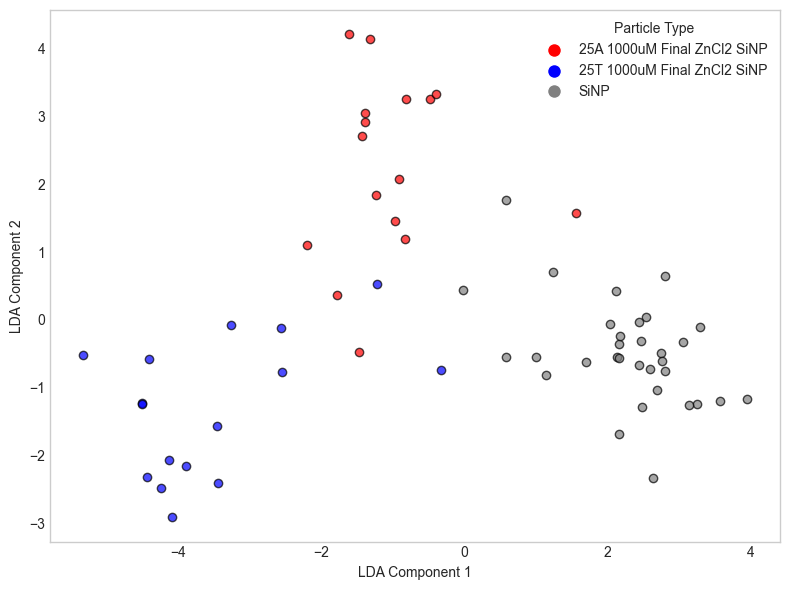

In [16]:
# Encoding particle type as a numeric label for comparison
DNA_SiNPs_data['Particle Type Label'], type_labels = pd.factorize(DNA_SiNPs_data['Particle Type'])

# Dropping particle type for clustering
X = DNA_SiNPs_data.drop(columns=["Particle Type", "Particle Type Label"])

# Standardising the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying LDA for dimensionality reduction
lda = LDA(n_components=2)
X_reduced = lda.fit_transform(X_scaled, DNA_SiNPs_data['Particle Type Label'])

# Plotting a single graph
fig, ax = plt.subplots(figsize=(8, 6))

# Plotting the true particles as a scatter plot
for particle_type, label in enumerate(type_labels):
    ax.scatter(
        X_reduced[DNA_SiNPs_data['Particle Type Label'] == particle_type, 0],
        X_reduced[DNA_SiNPs_data['Particle Type Label'] == particle_type, 1],
        label=f"{label}",
        alpha=0.7,
        color=particle_colours[label],
        edgecolors='black'
    )

# Creating handles for the particle type legend using circles for particles
particle_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=particle_colours[label], markersize=10, label=f'{label}') for label in type_labels]

# Adding particle type legend
ax.legend(handles=particle_handles, title="Particle Type", loc="upper right")

# Axes labels
ax.set_xlabel("LDA Component 1")
ax.set_ylabel("LDA Component 2")

# Displaying the plot
plt.grid(False)
plt.tight_layout()
plt.show()

C:\Users\tjwil\AppData\Local\Temp\ipykernel_13996\950620825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T25_data['Particle Type Label'], type_labels = pd.factorize(T25_data['Particle Type'])


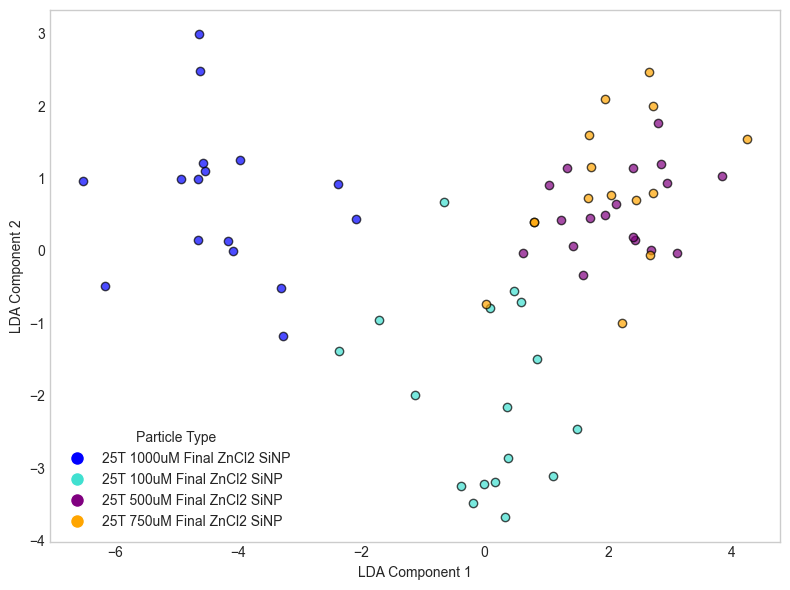

In [17]:
# Encoding particle type as a numeric label for comparison
T25_data['Particle Type Label'], type_labels = pd.factorize(T25_data['Particle Type'])

# Dropping particle type for clustering
X = T25_data.drop(columns=["Particle Type", "Particle Type Label"])

# Standardising the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying LDA for dimensionality reduction
lda = LDA(n_components=2)
X_reduced = lda.fit_transform(X_scaled, T25_data['Particle Type Label'])

# Plotting a single graph
fig, ax = plt.subplots(figsize=(8, 6))  # Single plot

# Plotting the true particles as a scatter plot
for particle_type, label in enumerate(type_labels):
    ax.scatter(
        X_reduced[T25_data['Particle Type Label'] == particle_type, 0],
        X_reduced[T25_data['Particle Type Label'] == particle_type, 1],
        label=f"{label}",
        alpha=0.7,
        color=particle_colours[label],
        edgecolors='black'
    )

# Creating handles for the particle type legend using circles for particles
particle_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=particle_colours[label], markersize=10, label=f'{label}') for label in type_labels]

# Adding particle type legend
ax.legend(handles=particle_handles, title="Particle Type", loc="lower left")

# Axes labels
ax.set_xlabel("LDA Component 1")
ax.set_ylabel("LDA Component 2")

# Displaying the plot
plt.grid(False)
plt.tight_layout()
plt.show()

---
# Random forest analysis and confusion matrix and ROC curves

### DNA_SiNPs_data

In [18]:
# Reading the DNA_SiNPs_data.csv
DNA_SiNPs_data = pd.read_csv("DNA_SiNPs_data.csv")

# Preprocessing the data by features and target variable
X = DNA_SiNPs_data.drop('Particle Type', axis=1)
y = DNA_SiNPs_data['Particle Type']

# Splitting the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# The parameter grid to iterate through to find the best random forest model
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initial random forest training and feature importance evaluation
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Getting feature importance scores
feature_importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
top_features = feature_importances.index.tolist()

# Selecting top features and tuning hyperparameters
best_accuracy = 0
best_params = None
best_features = None

# Initialising the progress bar
total_iterations = len(top_features)
with tqdm(total=total_iterations, desc="Feature Subset Iterations", unit="features") as pbar:
    for num_features in range(1, len(top_features) + 1):
        selected_features = top_features[:num_features]
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]

        # Performing GridSearchCV for hyperparameter tuning
        grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_subset, y_train)

        # Evaluating the test set
        y_pred = grid_search.best_estimator_.predict(X_test_subset)
        accuracy = accuracy_score(y_test, y_pred)

        # Checking if this is the best model based upon accuracy score
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = grid_search.best_params_
            best_features = selected_features

        # Updating the progress bar
        pbar.update(1)

# Training the best model and generate additional outputs
best_clf = RandomForestClassifier(**best_params, random_state=42)
best_clf.fit(X_train[best_features], y_train)
y_pred = best_clf.predict(X_test[best_features])
classification_rep = classification_report(y_test, y_pred)

# Saving feature importances and classification report
final_feature_importances = pd.Series(best_clf.feature_importances_, index=best_features)

# Binarizing the target labels for multiclass ROC curve
lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train)
y_test_bin = lb.transform(y_test)

# Getting predicted probabilities for each class
y_prob = best_clf.predict_proba(X_test[best_features])

# Generating ROC variables and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

# Iterating through each class and plot the ROC curve
for i, particle_label in enumerate(lb.classes_):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

Feature Subset Iterations: 100%|██████████| 26/26 [05:27<00:00, 12.58s/features]


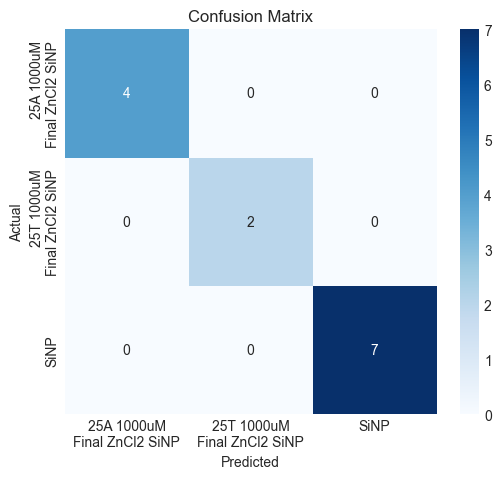

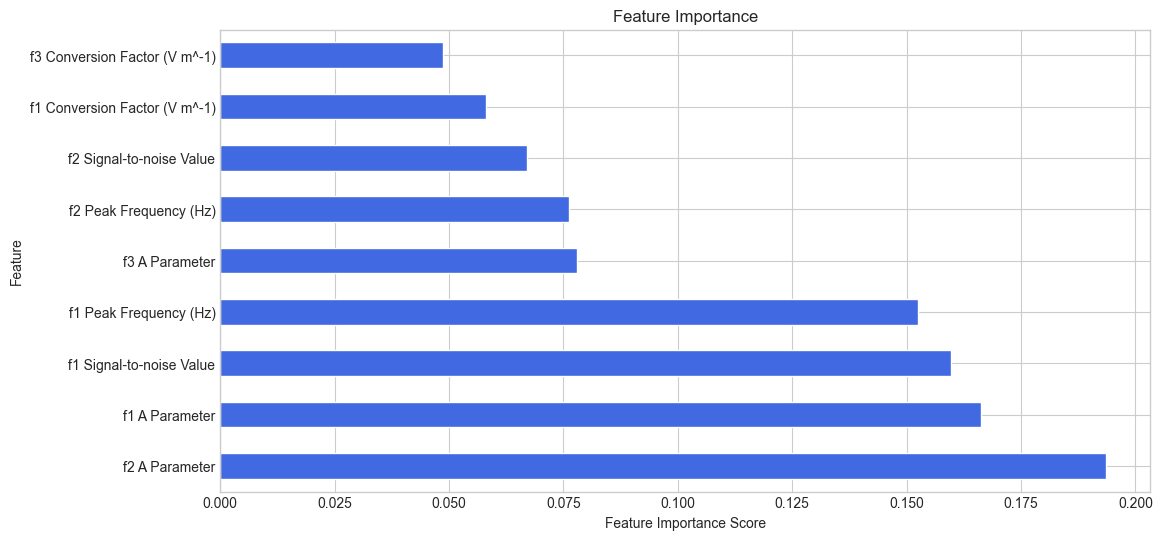

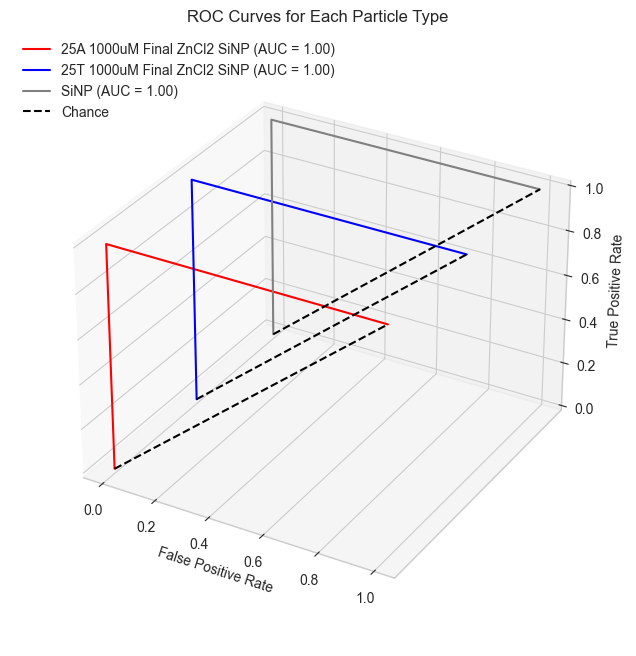

Best Model Results
Accuracy: 1.00
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}

Best Features: f2 A Parameter, f1 A Parameter, f1 Signal-to-noise Value, f3 A Parameter, f1 Conversion Factor (V m^-1), f2 Peak Frequency (Hz), f1 Peak Frequency (Hz), f3 Conversion Factor (V m^-1), f2 Signal-to-noise Value
Detailed Model Results


Accuracy: 1.00


Classification Report:

                             precision    recall  f1-score   support

25A 1000uM Final ZnCl2 SiNP       1.00      1.00      1.00         4
25T 1000uM Final ZnCl2 SiNP       1.00      1.00      1.00         2
                       SiNP       1.00      1.00      1.00         7

                   accuracy                           1.00        13
                  macro avg       1.00      1.00      1.00        13
               weighted avg       1.00      1.00      1.00        13



Feature Importances:

f2 A Parameter                   0.193572
f1 A Paramete

In [19]:
# Generating the confusion matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)

# Formatting the labels with a space halfway through multi-word labels
def format_label(label):
    words = label.split()
    if len(words) > 1:
        mid_point = len(words) // 2
        return ' '.join(words[:mid_point]) + '\n' + ' '.join(words[mid_point:])
    return label

formatted_labels = [format_label(label) for label in lb.classes_]

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=formatted_labels, yticklabels=formatted_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.xticks(rotation=0)
plt.yticks(rotation=90)
plt.show()

# Outputting the classification report and ranked feature importance as a dataframe
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Calculating and ranking feature importance
final_feature_importances = pd.Series(best_clf.feature_importances_, index=best_features).sort_values(ascending=False)
feature_importance_df = pd.DataFrame({'Feature': final_feature_importances.index, 'Importance': final_feature_importances.values})

# Plotting feature importance
plt.figure(figsize=(12, 6))
final_feature_importances.plot(kind='barh', color='royalblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

# Plotting ROC Curves as 3D plots
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Colours for ROC curves
colors = ['red', 'blue', 'gray']

for i, particle_label in enumerate(lb.classes_):
    ax.plot(fpr[i], tpr[i], zs=i, zdir='y', color=colors[i % len(colors)], label=f"{particle_label} (AUC = {roc_auc[i]:.2f})")

# Adding diagonal dashed lines for chance score
chance_x = np.linspace(0, 1, 100)
chance_y = np.linspace(0, 1, 100)
for i in range(len(lb.classes_)):
    ax.plot(chance_x, chance_y, zs=i, zdir='y', linestyle='dashed', color='black', label='Chance' if i == 0 else "")

ax.set_xlabel("False Positive Rate")
ax.set_zlabel("True Positive Rate")
ax.set_title("ROC Curves for Each Particle Type")
ax.legend(loc="upper left")
ax.set_yticks([])
ax.set_box_aspect(None, zoom=0.9)
plt.show()

# Printing the best model results
print("Best Model Results")
print("===================")
print(f"Accuracy: {best_accuracy:.2f}")
print(f"Best Hyperparameters: {best_params}\n")
print(f"Best Features: {', '.join(best_features)}")

# Printing the detailed model results
print("Detailed Model Results\n")
print("=======================\n")
print(f"Accuracy: {best_accuracy:.2f}\n\n")
print("Classification Report:\n")
print(classification_rep)
print("\n\nFeature Importances:\n")
print(final_feature_importances.sort_values(ascending=False).to_string())

### T25_data

In [20]:
# Reading the T25_data.csv
T25_data = pd.read_csv("T25_data.csv")

# Preprocessing the data by features and target variable
X = T25_data.drop('Particle Type', axis=1)
y = T25_data['Particle Type']

# Splitting the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# The parameter grid to iterate through to find the best random forest model
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initial random forest training and feature importance evaluation
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Getting feature importance scores
feature_importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
top_features = feature_importances.index.tolist()

# Selecting top features and tuning hyperparameters
best_accuracy = 0
best_params = None
best_features = None

# Initialising the progress bar
total_iterations = len(top_features)
with tqdm(total=total_iterations, desc="Feature Subset Iterations", unit="features") as pbar:
    for num_features in range(1, len(top_features) + 1):
        selected_features = top_features[:num_features]
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]

        # Performing GridSearchCV for hyperparameter tuning
        grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_subset, y_train)

        # Evaluating the test set
        y_pred = grid_search.best_estimator_.predict(X_test_subset)
        accuracy = accuracy_score(y_test, y_pred)

        # Checking if this is the best model based upon accuracy score
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = grid_search.best_params_
            best_features = selected_features

        # Updating the progress bar
        pbar.update(1)

# Training the best model and generate additional outputs
best_clf = RandomForestClassifier(**best_params, random_state=42)
best_clf.fit(X_train[best_features], y_train)
y_pred = best_clf.predict(X_test[best_features])
classification_rep = classification_report(y_test, y_pred)

# Saving feature importances and classification report
final_feature_importances = pd.Series(best_clf.feature_importances_, index=best_features)

# Binarizing the target labels for multiclass ROC curve
lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train)
y_test_bin = lb.transform(y_test)

# Getting predicted probabilities for each class
y_prob = best_clf.predict_proba(X_test[best_features])

# Generating ROC variables and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

# Iterating through each class and plot the ROC curve
for i, particle_label in enumerate(lb.classes_):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

Feature Subset Iterations: 100%|██████████| 26/26 [04:35<00:00, 10.58s/features]


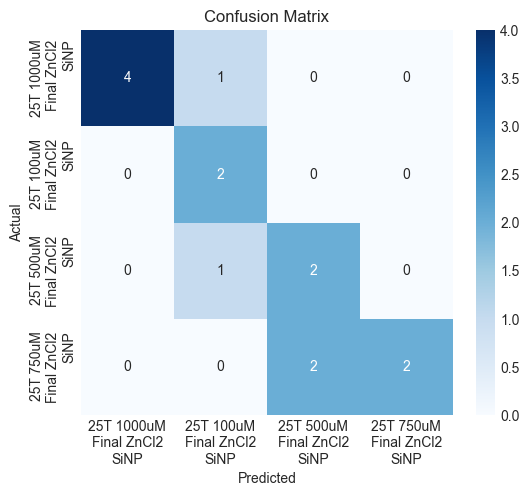

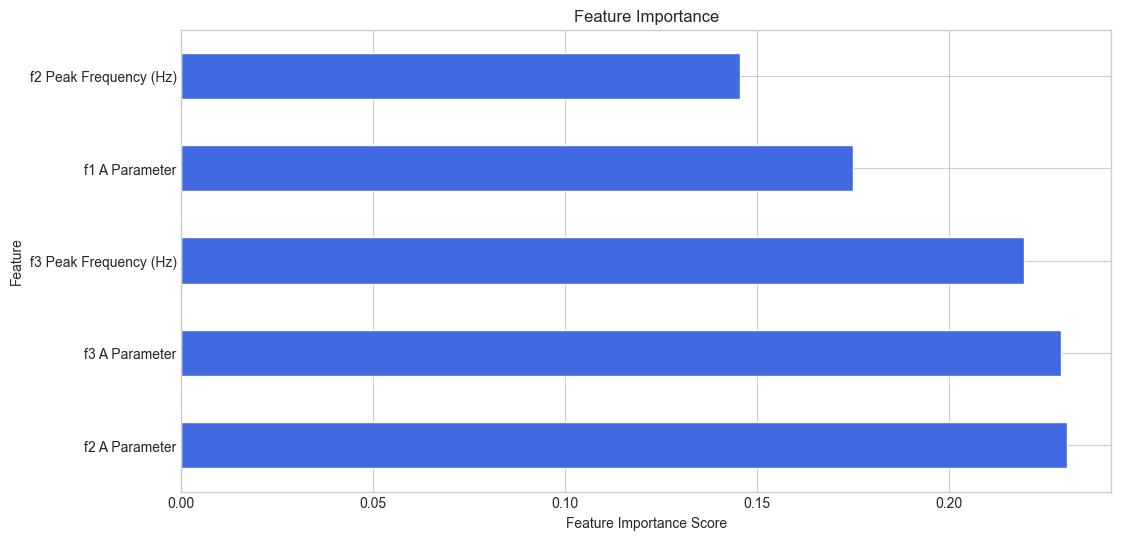

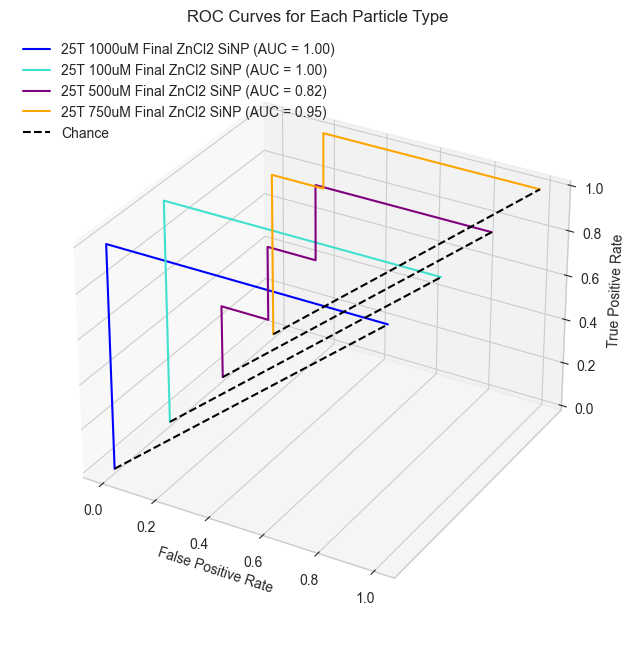

Best Model Results
Accuracy: 0.71
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}

Best Features: f3 A Parameter, f2 A Parameter, f2 Peak Frequency (Hz), f1 A Parameter, f3 Peak Frequency (Hz)
Detailed Model Results


Accuracy: 0.71


Classification Report:

                             precision    recall  f1-score   support

25T 1000uM Final ZnCl2 SiNP       1.00      0.80      0.89         5
 25T 100uM Final ZnCl2 SiNP       0.50      1.00      0.67         2
 25T 500uM Final ZnCl2 SiNP       0.50      0.67      0.57         3
 25T 750uM Final ZnCl2 SiNP       1.00      0.50      0.67         4

                   accuracy                           0.71        14
                  macro avg       0.75      0.74      0.70        14
               weighted avg       0.82      0.71      0.73        14



Feature Importances:

f2 A Parameter            0.230730
f3 A Parameter            0.229042
f3 Peak Frequency (Hz)    0.219

In [21]:
# Generating the confusion matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)

# Formatting the labels with a line break after every two words
def format_label(label):
    words = label.split()
    if len(words) > 1:
        formatted_label = ''
        for i in range(0, len(words), 2):
            formatted_label += ' '.join(words[i:i+2]) + '\n'
        return formatted_label.strip()
    return label

formatted_labels = [format_label(label) for label in lb.classes_]

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=formatted_labels, yticklabels=formatted_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.xticks(rotation=0)
plt.yticks(rotation=90)
plt.show()

# Outputting the classification report and ranked feature importance as a dataframe
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Calculating and ranking feature importance
final_feature_importances = pd.Series(best_clf.feature_importances_, index=best_features).sort_values(ascending=False)
feature_importance_df = pd.DataFrame({'Feature': final_feature_importances.index, 'Importance': final_feature_importances.values})

# Plotting feature importance
plt.figure(figsize=(12, 6))
final_feature_importances.plot(kind='barh', color='royalblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

# Plotting ROC Curves as 3D plots
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Colours for ROC curves
colors = ['blue', 'turquoise', 'purple', 'orange']  # Extend if more classes exist

for i, particle_label in enumerate(lb.classes_):
    ax.plot(fpr[i], tpr[i], zs=i, zdir='y', color=colors[i % len(colors)], label=f"{particle_label} (AUC = {roc_auc[i]:.2f})")

# Adding diagonal dashed lines for chance score
chance_x = np.linspace(0, 1, 100)
chance_y = np.linspace(0, 1, 100)
for i in range(len(lb.classes_)):
    ax.plot(chance_x, chance_y, zs=i, zdir='y', linestyle='dashed', color='black', label='Chance' if i == 0 else "")

ax.set_xlabel("False Positive Rate")
ax.set_zlabel("True Positive Rate")
ax.set_title("ROC Curves for Each Particle Type")
ax.legend(loc="upper left")
ax.set_yticks([])
ax.set_box_aspect(None, zoom=0.9)
plt.show()

# Printing the best model results
print("Best Model Results")
print("===================")
print(f"Accuracy: {best_accuracy:.2f}")
print(f"Best Hyperparameters: {best_params}\n")
print(f"Best Features: {', '.join(best_features)}")

# Printing the detailed model results
print("Detailed Model Results\n")
print("=======================\n")
print(f"Accuracy: {best_accuracy:.2f}\n\n")
print("Classification Report:\n")
print(classification_rep)
print("\n\nFeature Importances:\n")
print(final_feature_importances.sort_values(ascending=False).to_string())

---
# Repeating the data analysis with outliers included

In [22]:
# Creating the dataset with only 25A and 25T at 1000uM concentration and SiNP
DNA_SiNPs_data_with_outliers = s2n_data.loc[s2n_data['Particle Type'].isin([
    '25A 1000uM Final ZnCl2 SiNP',
    '25T 1000uM Final ZnCl2 SiNP',
    'SiNP'
])]

# Saving the dataset to a .csv file
DNA_SiNPs_data_with_outliers.to_csv("DNA_SiNPs_data_with_outliers.csv", index=False)

# Creating the dataset with all of the 25T data at different ZnCl2 concentrations
T25_data_with_outliers = s2n_data.loc[s2n_data['Particle Type'].isin([
    '25T 100uM Final ZnCl2 SiNP',
    '25T 500uM Final ZnCl2 SiNP',
    '25T 750uM Final ZnCl2 SiNP',
    '25T 1000uM Final ZnCl2 SiNP'
])]

# Saving the dataset to a .csv file
T25_data_with_outliers.to_csv("T25_data_with_outliers.csv", index=False)

---
# Linear Discriminant Analysis (LDA) Plots with Outliers

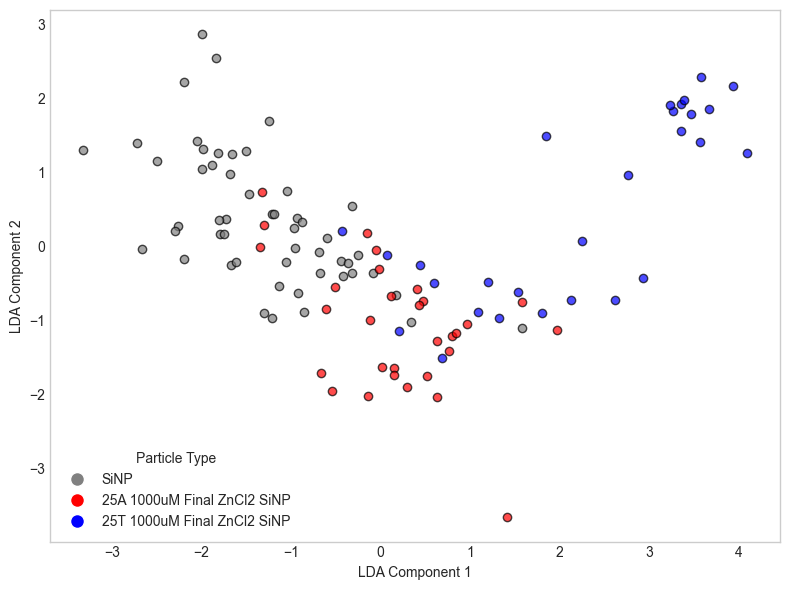

In [41]:
# Encoding particle type as a numeric label for comparison
DNA_SiNPs_data_with_outliers['Particle Type Label'], type_labels = pd.factorize(DNA_SiNPs_data_with_outliers['Particle Type'])

# Dropping particle type for clustering
X = DNA_SiNPs_data_with_outliers.drop(columns=["Particle Type", "Particle Type Label"])

# Standardising the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying LDA for dimensionality reduction
lda = LDA(n_components=2)
X_reduced = lda.fit_transform(X_scaled, DNA_SiNPs_data_with_outliers['Particle Type Label'])

# Plotting a single graph
fig, ax = plt.subplots(figsize=(8, 6))

# Plotting the true particles as a scatter plot
for particle_type, label in enumerate(type_labels):
    ax.scatter(
        X_reduced[DNA_SiNPs_data_with_outliers['Particle Type Label'] == particle_type, 0],
        X_reduced[DNA_SiNPs_data_with_outliers['Particle Type Label'] == particle_type, 1],
        label=f"{label}",
        alpha=0.7,
        color=particle_colours[label],
        edgecolors='black'
    )

# Creating handles for the particle type legend using circles for particles
particle_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=particle_colours[label], markersize=10, label=f'{label}') for label in type_labels]

# Adding particle type legend
ax.legend(handles=particle_handles, title="Particle Type", loc="lower left")

# Axes labels
ax.set_xlabel("LDA Component 1")
ax.set_ylabel("LDA Component 2")

# Displaying the plot
plt.grid(False)
plt.tight_layout()
plt.show()

C:\Users\tjwil\AppData\Local\Temp\ipykernel_13996\280636014.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T25_data_with_outliers['Particle Type Label'], type_labels = pd.factorize(T25_data_with_outliers['Particle Type'])


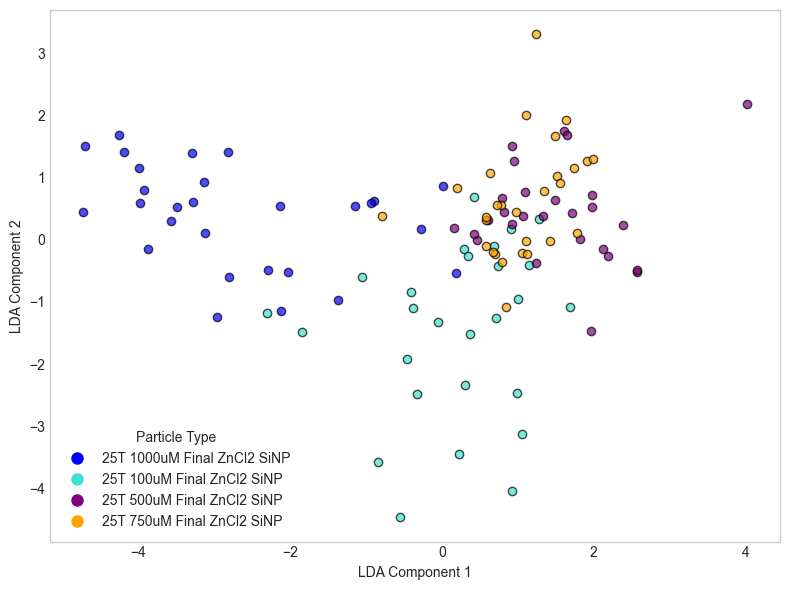

In [24]:
# Encoding particle type as a numeric label for comparison
T25_data_with_outliers['Particle Type Label'], type_labels = pd.factorize(T25_data_with_outliers['Particle Type'])

# Dropping particle type for clustering
X = T25_data_with_outliers.drop(columns=["Particle Type", "Particle Type Label"])

# Standardising the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying LDA for dimensionality reduction
lda = LDA(n_components=2)
X_reduced = lda.fit_transform(X_scaled, T25_data_with_outliers['Particle Type Label'])

# Plotting a single graph
fig, ax = plt.subplots(figsize=(8, 6))  # Single plot

# Plotting the true particles as a scatter plot
for particle_type, label in enumerate(type_labels):
    ax.scatter(
        X_reduced[T25_data_with_outliers['Particle Type Label'] == particle_type, 0],
        X_reduced[T25_data_with_outliers['Particle Type Label'] == particle_type, 1],
        label=f"{label}",
        alpha=0.7,
        color=particle_colours[label],
        edgecolors='black'
    )

# Creating handles for the particle type legend using circles for particles
particle_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=particle_colours[label], markersize=10, label=f'{label}') for label in type_labels]

# Adding particle type legend
ax.legend(handles=particle_handles, title="Particle Type", loc="lower left")

# Axes labels
ax.set_xlabel("LDA Component 1")
ax.set_ylabel("LDA Component 2")

# Displaying the plot
plt.grid(False)
plt.tight_layout()
plt.show()

---
# Random forest analysis and confusion matrix and ROC curves with outliers

### DNA_SiNPs_data

In [25]:
# Reading the DNA_SiNPs_data.csv
DNA_SiNPs_data_with_outliers = pd.read_csv("DNA_SiNPs_data_with_outliers.csv")

# Preprocessing the data by features and target variable
X = DNA_SiNPs_data_with_outliers.drop('Particle Type', axis=1)
y = DNA_SiNPs_data_with_outliers['Particle Type']

# Splitting the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# The parameter grid to iterate through to find the best random forest model
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initial random forest training and feature importance evaluation
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Getting feature importance scores
feature_importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
top_features = feature_importances.index.tolist()

# Selecting top features and tuning hyperparameters
best_accuracy = 0
best_params = None
best_features = None

# Initialising the progress bar
total_iterations = len(top_features)
with tqdm(total=total_iterations, desc="Feature Subset Iterations", unit="features") as pbar:
    for num_features in range(1, len(top_features) + 1):
        selected_features = top_features[:num_features]
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]

        # Performing GridSearchCV for hyperparameter tuning
        grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_subset, y_train)

        # Evaluating the test set
        y_pred = grid_search.best_estimator_.predict(X_test_subset)
        accuracy = accuracy_score(y_test, y_pred)

        # Checking if this is the best model based upon accuracy score
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = grid_search.best_params_
            best_features = selected_features

        # Updating the progress bar
        pbar.update(1)

# Training the best model and generate additional outputs
best_clf = RandomForestClassifier(**best_params, random_state=42)
best_clf.fit(X_train[best_features], y_train)
y_pred = best_clf.predict(X_test[best_features])
classification_rep = classification_report(y_test, y_pred)

# Saving feature importances and classification report
final_feature_importances = pd.Series(best_clf.feature_importances_, index=best_features)

# Binarizing the target labels for multiclass ROC curve
lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train)
y_test_bin = lb.transform(y_test)

# Getting predicted probabilities for each class
y_prob = best_clf.predict_proba(X_test[best_features])

# Generating ROC variables and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

# Iterating through each class and plot the ROC curve
for i, particle_label in enumerate(lb.classes_):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

Feature Subset Iterations: 100%|██████████| 26/26 [04:22<00:00, 10.08s/features]


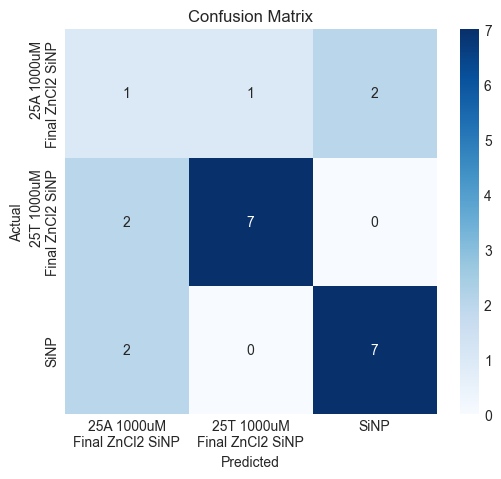

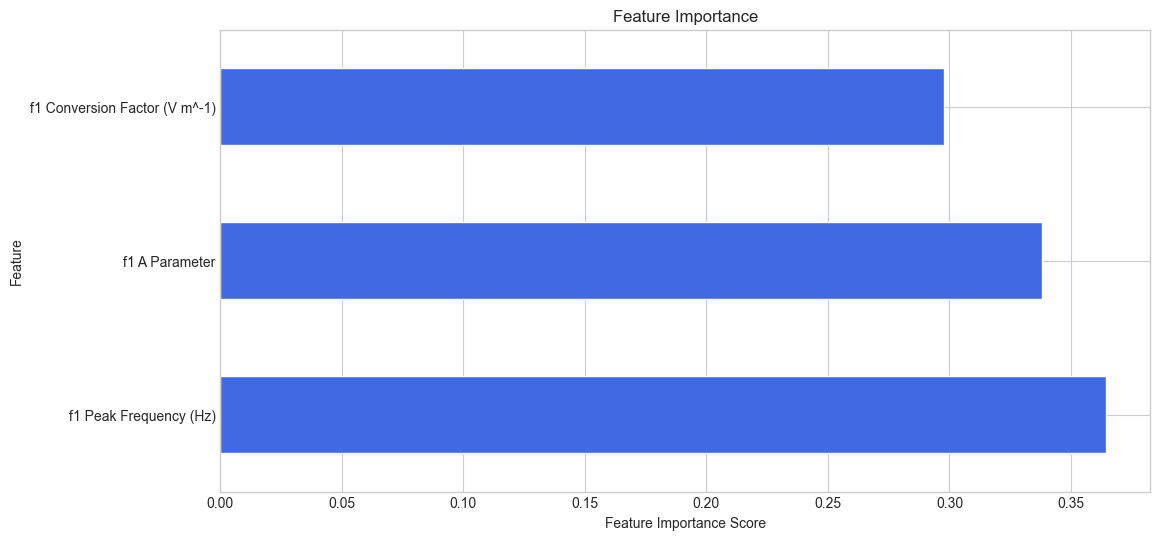

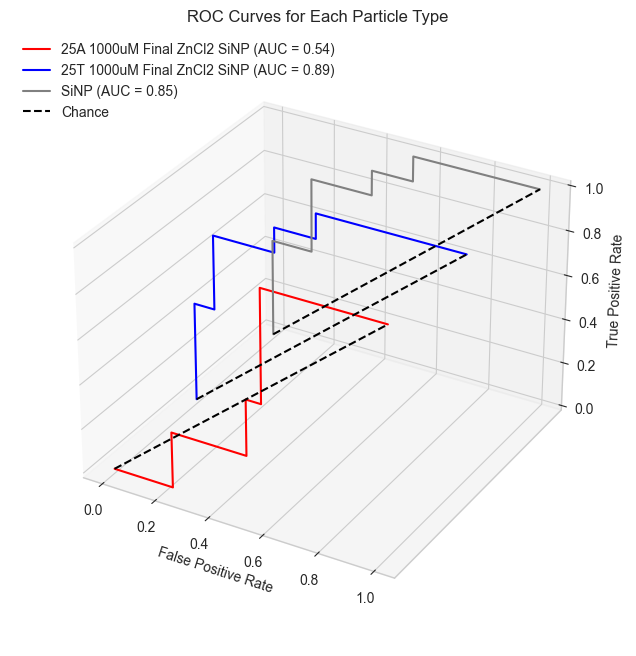

Best Model Results
Accuracy: 0.68
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

Best Features: f1 Peak Frequency (Hz), f1 A Parameter, f1 Conversion Factor (V m^-1)
Detailed Model Results


Accuracy: 0.68


Classification Report:

                             precision    recall  f1-score   support

25A 1000uM Final ZnCl2 SiNP       0.20      0.25      0.22         4
25T 1000uM Final ZnCl2 SiNP       0.88      0.78      0.82         9
                       SiNP       0.78      0.78      0.78         9

                   accuracy                           0.68        22
                  macro avg       0.62      0.60      0.61        22
               weighted avg       0.71      0.68      0.70        22



Feature Importances:

f1 Peak Frequency (Hz)           0.364417
f1 A Parameter                   0.338019
f1 Conversion Factor (V m^-1)    0.297565


In [26]:
# Generating the confusion matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)

# Formatting the labels with a space halfway through multi-word labels
def format_label(label):
    words = label.split()
    if len(words) > 1:
        mid_point = len(words) // 2
        return ' '.join(words[:mid_point]) + '\n' + ' '.join(words[mid_point:])
    return label

formatted_labels = [format_label(label) for label in lb.classes_]

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=formatted_labels, yticklabels=formatted_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.xticks(rotation=0)
plt.yticks(rotation=90)
plt.show()

# Outputting the classification report and ranked feature importance as a dataframe
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Calculating and ranking feature importance
final_feature_importances = pd.Series(best_clf.feature_importances_, index=best_features).sort_values(ascending=False)
feature_importance_df = pd.DataFrame({'Feature': final_feature_importances.index, 'Importance': final_feature_importances.values})

# Plotting feature importance
plt.figure(figsize=(12, 6))
final_feature_importances.plot(kind='barh', color='royalblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

# Plotting ROC Curves as 3D plots
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Colours for ROC curves
colors = ['red', 'blue', 'gray']

for i, particle_label in enumerate(lb.classes_):
    ax.plot(fpr[i], tpr[i], zs=i, zdir='y', color=colors[i % len(colors)], label=f"{particle_label} (AUC = {roc_auc[i]:.2f})")

# Adding diagonal dashed lines for chance score
chance_x = np.linspace(0, 1, 100)
chance_y = np.linspace(0, 1, 100)
for i in range(len(lb.classes_)):
    ax.plot(chance_x, chance_y, zs=i, zdir='y', linestyle='dashed', color='black', label='Chance' if i == 0 else "")

ax.set_xlabel("False Positive Rate")
ax.set_zlabel("True Positive Rate")
ax.set_title("ROC Curves for Each Particle Type")
ax.legend(loc="upper left")
ax.set_yticks([])
ax.set_box_aspect(None, zoom=0.9)
plt.show()

# Printing the best model results
print("Best Model Results")
print("===================")
print(f"Accuracy: {best_accuracy:.2f}")
print(f"Best Hyperparameters: {best_params}\n")
print(f"Best Features: {', '.join(best_features)}")

# Printing the detailed model results
print("Detailed Model Results\n")
print("=======================\n")
print(f"Accuracy: {best_accuracy:.2f}\n\n")
print("Classification Report:\n")
print(classification_rep)
print("\n\nFeature Importances:\n")
print(final_feature_importances.sort_values(ascending=False).to_string())

### T25_data

In [27]:
# Reading the T25_data.csv
T25_data_with_outliers = pd.read_csv("T25_data_with_outliers.csv")

# Preprocessing the data by features and target variable
X = T25_data_with_outliers.drop('Particle Type', axis=1)
y = T25_data_with_outliers['Particle Type']

# Splitting the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# The parameter grid to iterate through to find the best random forest model
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initial random forest training and feature importance evaluation
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Getting feature importance scores
feature_importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
top_features = feature_importances.index.tolist()

# Selecting top features and tuning hyperparameters
best_accuracy = 0
best_params = None
best_features = None

# Initialising the progress bar
total_iterations = len(top_features)
with tqdm(total=total_iterations, desc="Feature Subset Iterations", unit="features") as pbar:
    for num_features in range(1, len(top_features) + 1):
        selected_features = top_features[:num_features]
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]

        # Performing GridSearchCV for hyperparameter tuning
        grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_subset, y_train)

        # Evaluating the test set
        y_pred = grid_search.best_estimator_.predict(X_test_subset)
        accuracy = accuracy_score(y_test, y_pred)

        # Checking if this is the best model based upon accuracy score
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = grid_search.best_params_
            best_features = selected_features

        # Updating the progress bar
        pbar.update(1)

# Training the best model and generate additional outputs
best_clf = RandomForestClassifier(**best_params, random_state=42)
best_clf.fit(X_train[best_features], y_train)
y_pred = best_clf.predict(X_test[best_features])
classification_rep = classification_report(y_test, y_pred)

# Saving feature importances and classification report
final_feature_importances = pd.Series(best_clf.feature_importances_, index=best_features)

# Binarizing the target labels for multiclass ROC curve
lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train)
y_test_bin = lb.transform(y_test)

# Getting predicted probabilities for each class
y_prob = best_clf.predict_proba(X_test[best_features])

# Generating ROC variables and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

# Iterating through each class and plot the ROC curve
for i, particle_label in enumerate(lb.classes_):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

Feature Subset Iterations: 100%|██████████| 26/26 [04:15<00:00,  9.84s/features]


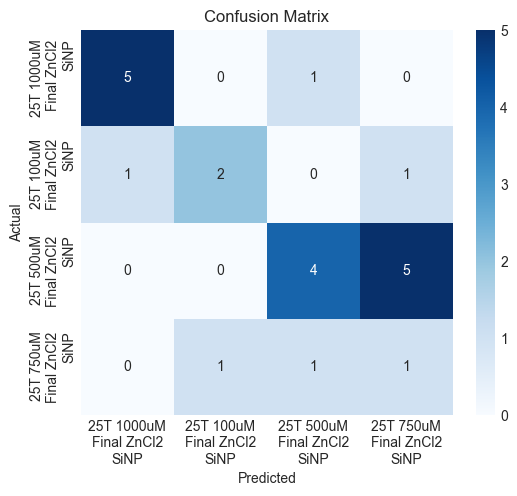

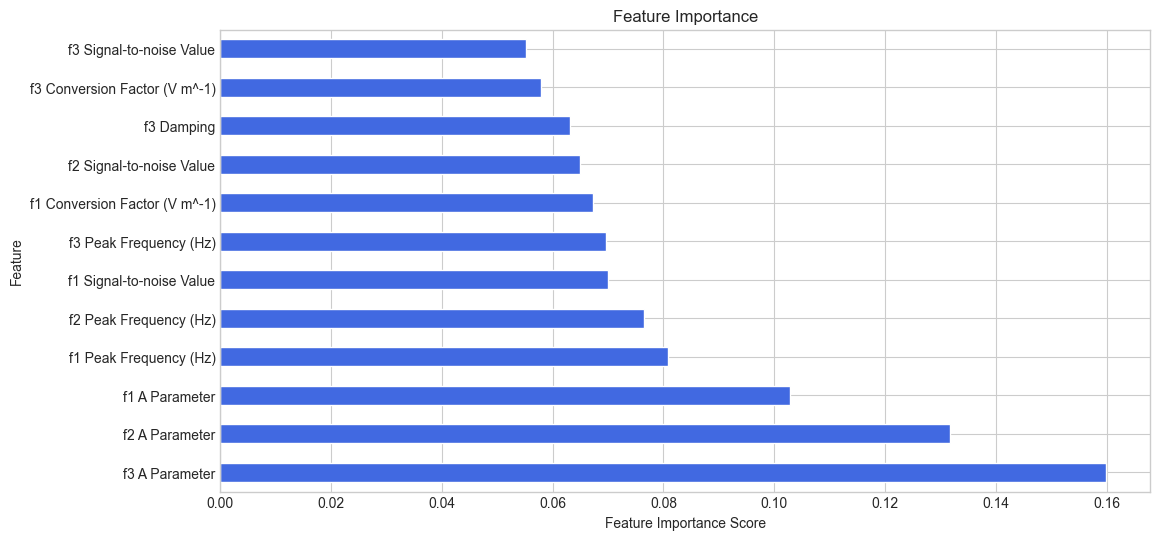

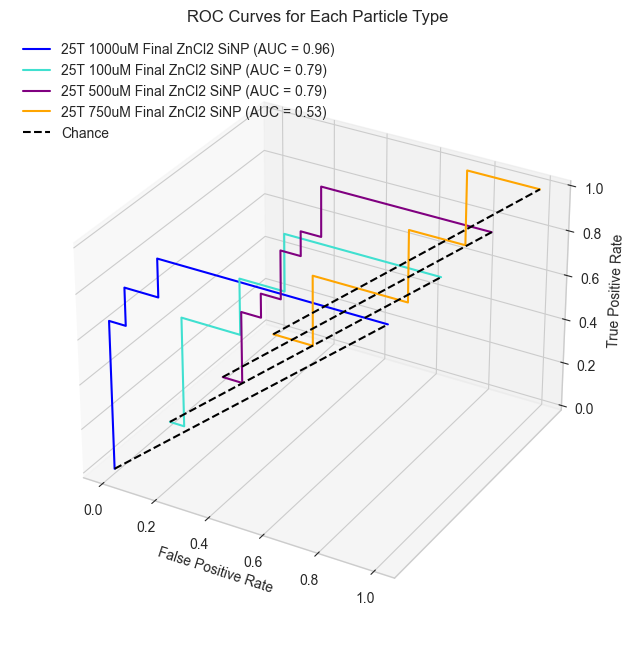

Best Model Results
Accuracy: 0.55
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

Best Features: f3 A Parameter, f2 A Parameter, f1 A Parameter, f2 Signal-to-noise Value, f1 Peak Frequency (Hz), f3 Signal-to-noise Value, f2 Peak Frequency (Hz), f1 Signal-to-noise Value, f3 Conversion Factor (V m^-1), f1 Conversion Factor (V m^-1), f3 Damping, f3 Peak Frequency (Hz)
Detailed Model Results


Accuracy: 0.55


Classification Report:

                             precision    recall  f1-score   support

25T 1000uM Final ZnCl2 SiNP       0.83      0.83      0.83         6
 25T 100uM Final ZnCl2 SiNP       0.67      0.50      0.57         4
 25T 500uM Final ZnCl2 SiNP       0.67      0.44      0.53         9
 25T 750uM Final ZnCl2 SiNP       0.14      0.33      0.20         3

                   accuracy                           0.55        22
                  macro avg       0.58      0.53      0.53        22
               wei

In [28]:
# Generating the confusion matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)

# Formatting the labels with a line break after every two words
def format_label(label):
    words = label.split()
    if len(words) > 1:
        formatted_label = ''
        for i in range(0, len(words), 2):
            formatted_label += ' '.join(words[i:i+2]) + '\n'
        return formatted_label.strip()
    return label

formatted_labels = [format_label(label) for label in lb.classes_]

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=formatted_labels, yticklabels=formatted_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.xticks(rotation=0)
plt.yticks(rotation=90)
plt.show()

# Outputting the classification report and ranked feature importance as a dataframe
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Calculating and ranking feature importance
final_feature_importances = pd.Series(best_clf.feature_importances_, index=best_features).sort_values(ascending=False)
feature_importance_df = pd.DataFrame({'Feature': final_feature_importances.index, 'Importance': final_feature_importances.values})

# Plotting feature importance
plt.figure(figsize=(12, 6))
final_feature_importances.plot(kind='barh', color='royalblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

# Plotting ROC Curves as 3D plots
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Colours for ROC curves
colors = ['blue', 'turquoise', 'purple', 'orange']  # Extend if more classes exist

for i, particle_label in enumerate(lb.classes_):
    ax.plot(fpr[i], tpr[i], zs=i, zdir='y', color=colors[i % len(colors)], label=f"{particle_label} (AUC = {roc_auc[i]:.2f})")

# Adding diagonal dashed lines for chance score
chance_x = np.linspace(0, 1, 100)
chance_y = np.linspace(0, 1, 100)
for i in range(len(lb.classes_)):
    ax.plot(chance_x, chance_y, zs=i, zdir='y', linestyle='dashed', color='black', label='Chance' if i == 0 else "")

ax.set_xlabel("False Positive Rate")
ax.set_zlabel("True Positive Rate")
ax.set_title("ROC Curves for Each Particle Type")
ax.legend(loc="upper left")
ax.set_yticks([])
ax.set_box_aspect(None, zoom=0.9)
plt.show()

# Printing the best model results
print("Best Model Results")
print("===================")
print(f"Accuracy: {best_accuracy:.2f}")
print(f"Best Hyperparameters: {best_params}\n")
print(f"Best Features: {', '.join(best_features)}")

# Printing the detailed model results
print("Detailed Model Results\n")
print("=======================\n")
print(f"Accuracy: {best_accuracy:.2f}\n\n")
print("Classification Report:\n")
print(classification_rep)
print("\n\nFeature Importances:\n")
print(final_feature_importances.sort_values(ascending=False).to_string())

---
# Frequency comparison charts
Note:
- The datasets here are provided in the repository as a compressed .7z file. Please extract these into a folder named compare_peaks_data.

In [29]:
# Loading the Rhode and Schwarz .bin oscilloscope data file
def get_bin_data(file):
    y, time_data, save_info = RTxReadBin(file)
    voltages = y[:, 0, 0]
    time_start = save_info["XStart"]
    time_stop = save_info["XStop"]
    signal_record_length = save_info["SignalRecordLength"]
    time_step = (time_stop - time_start) / signal_record_length
    sample_frequency = 1 / time_step
    data = oa.load_voltage_data(voltages, SampleFreq = sample_frequency, timeStart = time_start)
    return data

In [30]:
# Loading the sample compare_peaks.csv table
compare_peaks_table = pd.read_csv("compare_peaks.csv")
compare_peaks_table.head()

,SiNP,f1 SiNP Peak Freq (Hz),f2 SiNP Peak Freq (Hz),f3 SiNP Peak Freq (Hz),1000uM Final ZnCl2,f1 1000uM Final ZnCl2 Peak Freq (Hz),f2 1000uM Final ZnCl2 Peak Freq (Hz),f3 1000uM Final ZnCl2 Peak Freq (Hz),25A 1000uM Final ZnCl2,f1 25A 1000uM Final ZnCl2 Peak Freq (Hz),...,f2 25T 100uM Final ZnCl2 Peak Freq (Hz),f3 25T 100uM Final ZnCl2 Peak Freq (Hz),25T 500uM Final ZnCl2,f1 25T 500uM Final ZnCl2 Peak Freq (Hz),f2 25T 500uM Final ZnCl2 Peak Freq (Hz),f3 25T 500uM Final ZnCl2 Peak Freq (Hz),25T 750uM Final ZnCl2,f1 25T 750uM Final ZnCl2 Peak Freq (Hz),f2 25T 750uM Final ZnCl2 Peak Freq (Hz),f3 25T 750uM Final ZnCl2 Peak Freq (Hz)
0,compare_peaks_data/RefCurve_2025-01-07_1.Wfm.bin,134922,211863,239476,compare_peaks_data/RefCurve_2025-01-08_3.Wfm.bin,138675,214200,240542,compare_peaks_data/RefCurve_2025-01-09_3.Wfm.bin,135659,...,196562,216526,compare_peaks_data/RefCurve_2025-01-15_3.Wfm.bin,138160,213057,239462,compare_peaks_data/RefCurve_2025-01-17_2.Wfm.bin,134625,206953,232033
1,compare_peaks_data/RefCurve_2025-01-07_2.Wfm.bin,139785,213320,239286,compare_peaks_data/RefCurve_2025-01-08_4.Wfm.bin,134765,214006,242753,compare_peaks_data/RefCurve_2025-01-09_4.Wfm.bin,137007,...,198129,217631,compare_peaks_data/RefCurve_2025-01-15_5.Wfm.bin,138036,210859,236170,compare_peaks_data/RefCurve_2025-01-17_1.Wfm.bin,132480,204808,228050
2,compare_peaks_data/RefCurve_2025-01-07_6.Wfm.bin,136054,209189,234708,compare_peaks_data/RefCurve_2025-01-08_6.Wfm.bin,137234,215233,242930,compare_peaks_data/RefCurve_2025-01-09_9.Wfm.bin,135581,...,199125,218956,compare_peaks_data/RefCurve_2025-01-15_9.Wfm.bin,136442,208835,234303,compare_peaks_data/RefCurve_2025-01-17_5.Wfm.bin,133612,207739,233430
3,compare_peaks_data/RefCurve_2025-01-07_8.Wfm.bin,130264,199700,220940,compare_peaks_data/RefCurve_2025-01-08_11.Wfm.bin,135633,212475,239964,compare_peaks_data/RefCurve_2025-01-09_14.Wfm.bin,136459,...,199098,219210,compare_peaks_data/RefCurve_2025-01-15_10.Wfm.bin,137352,208791,233440,compare_peaks_data/RefCurve_2025-01-17_8.Wfm.bin,129774,201465,225190
4,compare_peaks_data/RefCurve_2025-01-07_11.Wfm.bin,137230,203313,224191,compare_peaks_data/RefCurve_2025-01-08_14.Wfm.bin,138198,216454,244179,compare_peaks_data/RefCurve_2025-01-09_16.Wfm.bin,135945,...,202947,226619,compare_peaks_data/RefCurve_2025-01-15_14.Wfm.bin,133368,193811,211430,compare_peaks_data/RefCurve_2025-01-17_13.Wfm.bin,136882,198773,217662


In [31]:
# Getting the limits for the f1 frequency values with a 2000 Hz buffer on either side
def get_f1_limits(row):
    columns =["f1 SiNP Peak Freq (Hz)", "f1 1000uM Final ZnCl2 Peak Freq (Hz)",
              "f1 25A 1000uM Final ZnCl2 Peak Freq (Hz)", "f1 25T 1000uM Final ZnCl2 Peak Freq (Hz)",
              "f1 25T 100uM Final ZnCl2 Peak Freq (Hz)", "f1 25T 500uM Final ZnCl2 Peak Freq (Hz)",
              "f1 25T 750uM Final ZnCl2 Peak Freq (Hz)"]
    min_value = row[columns].min() - 2000
    max_value = row[columns].max() + 2000
    return min_value, max_value

# Getting the limits for the f2 frequency values with a 2000 Hz buffer on either side
def get_f2_limits(row):
    columns =["f2 SiNP Peak Freq (Hz)", "f2 1000uM Final ZnCl2 Peak Freq (Hz)",
              "f2 25A 1000uM Final ZnCl2 Peak Freq (Hz)", "f2 25T 1000uM Final ZnCl2 Peak Freq (Hz)",
              "f2 25T 100uM Final ZnCl2 Peak Freq (Hz)", "f2 25T 500uM Final ZnCl2 Peak Freq (Hz)",
              "f2 25T 750uM Final ZnCl2 Peak Freq (Hz)"]
    min_value = row[columns].min() - 2000
    max_value = row[columns].max() + 2000
    return min_value, max_value

# Getting the limits for the f3 frequency values with a 2000 Hz buffer on either side
def get_f3_limits(row):
    columns =["f3 SiNP Peak Freq (Hz)", "f3 1000uM Final ZnCl2 Peak Freq (Hz)",
              "f3 25A 1000uM Final ZnCl2 Peak Freq (Hz)", "f3 25T 1000uM Final ZnCl2 Peak Freq (Hz)",
              "f3 25T 100uM Final ZnCl2 Peak Freq (Hz)", "f3 25T 500uM Final ZnCl2 Peak Freq (Hz)",
              "f3 25T 750uM Final ZnCl2 Peak Freq (Hz)"]
    min_value = row[columns].min() - 2000
    max_value = row[columns].max() + 2000
    return min_value, max_value

In [32]:
# Plotting the data with all particle types included
def plot_all_peaks(SiNP_data, ZnCl2_data, A1000_data, T1000_data, 
                     T100_data, T500_data, T750_data, f1_min_value, f1_max_value,
                     f2_min_value, f2_max_value, f3_min_value, f3_max_value):

    # Getting the frequency and PSD for each particle type
    SiNP_freq, SiNP_psd = SiNP_data.get_PSD()
    ZnCl2_freq, ZnCl2_psd = ZnCl2_data.get_PSD()
    A1000_freq, A1000_psd = A1000_data.get_PSD()
    T1000_freq, T1000_psd = T1000_data.get_PSD()
    T100_freq, T100_psd = T100_data.get_PSD()
    T500_freq, T500_psd = T500_data.get_PSD()
    T750_freq, T750_psd = T750_data.get_PSD()

    # Setting up the plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plotting the f1 peak in the first window
    axes[0].plot(SiNP_freq, SiNP_psd, color="gray", label="SiNPs")
    axes[0].plot(ZnCl2_freq, ZnCl2_psd, color="green", label="SiNPs 1000uM ZnCl2")
    axes[0].plot(A1000_freq, A1000_psd, color="red", label="25A 1000uM ZnCl2")
    axes[0].plot(T1000_freq, T1000_psd, color="blue", label="25T 1000uM ZnCl2")
    axes[0].plot(T100_freq, T100_psd, color="turquoise", label="25T 100uM ZnCl2")
    axes[0].plot(T500_freq, T500_psd, color="purple", label="25T 500uM ZnCl2")
    axes[0].plot(T750_freq, T750_psd, color="orange", label="25T 750uM ZnCl2")    
    axes[0].set_xlim(f1_min_value, f1_max_value)
    axes[0].set_yscale("log")
    axes[0].set_xlabel("Frequency (Hz)")
    axes[0].set_ylabel("$S_{xx}$ ($V^2/Hz$)")
    axes[0].set_title("Plot of all f1 Peaks")
    axes[0].grid(True)
    axes[0].legend(loc="lower right")

    # Plotting the f2 peak in the second window
    axes[1].plot(SiNP_freq, SiNP_psd, color="gray", label="SiNPs")
    axes[1].plot(ZnCl2_freq, ZnCl2_psd, color="green", label="SiNPs 1000uM ZnCl2")
    axes[1].plot(A1000_freq, A1000_psd, color="red", label="25A 1000uM ZnCl2")
    axes[1].plot(T1000_freq, T1000_psd, color="blue", label="25T 1000uM ZnCl2")
    axes[1].plot(T100_freq, T100_psd, color="turquoise", label="25T 100uM ZnCl2")
    axes[1].plot(T500_freq, T500_psd, color="purple", label="25T 500uM ZnCl2")
    axes[1].plot(T750_freq, T750_psd, color="orange", label="25T 750uM ZnCl2")    
    axes[1].set_xlim(f2_min_value, f2_max_value)
    axes[1].set_yscale("log")
    axes[1].set_xlabel("Frequency (Hz)")
    axes[1].set_ylabel("$S_{xx}$ ($V^2/Hz$)")
    axes[1].set_title("Plot of all f2 Peaks")
    axes[1].grid(True)
    axes[1].legend(loc="lower right")

    # Plotting the f3 peak in the third window
    axes[2].plot(SiNP_freq, SiNP_psd, color="gray", label="SiNPs")
    axes[2].plot(ZnCl2_freq, ZnCl2_psd, color="green", label="SiNPs 1000uM ZnCl2")
    axes[2].plot(A1000_freq, A1000_psd, color="red", label="25A 1000uM ZnCl2")
    axes[2].plot(T1000_freq, T1000_psd, color="blue", label="25T 1000uM ZnCl2")
    axes[2].plot(T100_freq, T100_psd, color="turquoise", label="25T 100uM ZnCl2")
    axes[2].plot(T500_freq, T500_psd, color="purple", label="25T 500uM ZnCl2")
    axes[2].plot(T750_freq, T750_psd, color="orange", label="25T 750uM ZnCl2")    
    axes[2].set_xlim(f3_min_value, f3_max_value)
    axes[2].set_yscale("log")
    axes[2].set_xlabel("Frequency (Hz)")
    axes[2].set_ylabel("$S_{xx}$ ($V^2/Hz$)")
    axes[2].set_title("Plot of all f3 Peaks")
    axes[2].grid(True)
    axes[2].legend(loc="lower right")

    # Displaying the plot
    plt.tight_layout()
    plt.show()

    return

In [33]:
# Plotting the data with only 25T particle types included
def plot_T_peaks(T1000_data, T100_data, T500_data, T750_data, f1_min_value, f1_max_value,
                     f2_min_value, f2_max_value, f3_min_value, f3_max_value):

    # Getting the frequency and PSD for each particle type
    T1000_freq, T1000_psd = T1000_data.get_PSD()
    T100_freq, T100_psd = T100_data.get_PSD()
    T500_freq, T500_psd = T500_data.get_PSD()
    T750_freq, T750_psd = T750_data.get_PSD()

    # Setting up the plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plotting the f1 peak in the first window
    axes[0].plot(T1000_freq, T1000_psd, color="blue", label="25T 1000uM ZnCl2")
    axes[0].plot(T100_freq, T100_psd, color="turquoise", label="25T 100uM ZnCl2")
    axes[0].plot(T500_freq, T500_psd, color="purple", label="25T 500uM ZnCl2")
    axes[0].plot(T750_freq, T750_psd, color="orange", label="25T 750uM ZnCl2")    
    axes[0].set_xlim(f1_min_value, f1_max_value)
    axes[0].set_yscale("log")
    axes[0].set_xlabel("Frequency (Hz)")
    axes[0].set_ylabel("$S_{xx}$ ($V^2/Hz$)")
    axes[0].set_title("Plot of 25T f1 Peaks")
    axes[0].grid(True)
    axes[0].legend(loc="lower right")

    # Plotting the f2 peak in the second window
    axes[1].plot(T1000_freq, T1000_psd, color="blue", label="25T 1000uM ZnCl2")
    axes[1].plot(T100_freq, T100_psd, color="turquoise", label="25T 100uM ZnCl2")
    axes[1].plot(T500_freq, T500_psd, color="purple", label="25T 500uM ZnCl2")
    axes[1].plot(T750_freq, T750_psd, color="orange", label="25T 750uM ZnCl2")    
    axes[1].set_xlim(f2_min_value, f2_max_value)
    axes[1].set_yscale("log")
    axes[1].set_xlabel("Frequency (Hz)")
    axes[1].set_ylabel("$S_{xx}$ ($V^2/Hz$)")
    axes[1].set_title("Plot of 25T f2 Peaks")
    axes[1].grid(True)
    axes[1].legend(loc="lower right")

    # Plotting the f3 peak in the third window
    axes[2].plot(T1000_freq, T1000_psd, color="blue", label="25T 1000uM ZnCl2")
    axes[2].plot(T100_freq, T100_psd, color="turquoise", label="25T 100uM ZnCl2")
    axes[2].plot(T500_freq, T500_psd, color="purple", label="25T 500uM ZnCl2")
    axes[2].plot(T750_freq, T750_psd, color="orange", label="25T 750uM ZnCl2")    
    axes[2].set_xlim(f3_min_value, f3_max_value)
    axes[2].set_yscale("log")
    axes[2].set_xlabel("Frequency (Hz)")
    axes[2].set_ylabel("$S_{xx}$ ($V^2/Hz$)")
    axes[2].set_title("Plot of 25T f3 Peaks")
    axes[2].grid(True)
    axes[2].legend(loc="lower right")

    # Displaying the plot
    plt.tight_layout()
    plt.show()

    return

In [34]:
# Plotting the data with only 25A, 25T and SiNP particle types included
def plot_SiNP_A_T_peaks(T1000_data, A1000_data, SiNP_data, f1_min_value, f1_max_value,
                     f2_min_value, f2_max_value, f3_min_value, f3_max_value):

    # Getting the frequency and PSD for each particle type
    T1000_freq, T1000_psd = T1000_data.get_PSD()
    A100_freq, A100_psd = A1000_data.get_PSD()
    SiNP_freq, SiNP_psd = SiNP_data.get_PSD()

    # Setting up the plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plotting the f1 peak in the first window
    axes[0].plot(T1000_freq, T1000_psd, color="blue", label="25T 1000uM ZnCl2")
    axes[0].plot(A100_freq, A100_psd, color="red", label="25A 1000uM ZnCl2")
    axes[0].plot(SiNP_freq, SiNP_psd, color="gray", label="SiNPs") 
    axes[0].set_xlim(f1_min_value, f1_max_value)
    axes[0].set_yscale("log")
    axes[0].set_xlabel("Frequency (Hz)")
    axes[0].set_ylabel("$S_{xx}$ ($V^2/Hz$)")
    axes[0].set_title("Plot of f1 Peaks")
    axes[0].grid(True)
    axes[0].legend(loc="lower right")

    # Plotting the f2 peak in the second window
    axes[1].plot(T1000_freq, T1000_psd, color="blue", label="25T 1000uM ZnCl2")
    axes[1].plot(A100_freq, A100_psd, color="red", label="25A 1000uM ZnCl2")
    axes[1].plot(SiNP_freq, SiNP_psd, color="gray", label="SiNPs")     
    axes[1].set_xlim(f2_min_value, f2_max_value)
    axes[1].set_yscale("log")
    axes[1].set_xlabel("Frequency (Hz)")
    axes[1].set_ylabel("$S_{xx}$ ($V^2/Hz$)")
    axes[1].set_title("Plot of f2 Peaks")
    axes[1].grid(True)
    axes[1].legend(loc="lower right")

    # Plotting the f3 peak in the third window
    axes[2].plot(T1000_freq, T1000_psd, color="blue", label="25T 1000uM ZnCl2")
    axes[2].plot(A100_freq, A100_psd, color="red", label="25A 1000uM ZnCl2")
    axes[2].plot(SiNP_freq, SiNP_psd, color="gray", label="SiNPs")    
    axes[2].set_xlim(f3_min_value, f3_max_value)
    axes[2].set_yscale("log")
    axes[2].set_xlabel("Frequency (Hz)")
    axes[2].set_ylabel("$S_{xx}$ ($V^2/Hz$)")
    axes[2].set_title("Plot of f3 Peaks")
    axes[2].grid(True)
    axes[2].legend(loc="lower right")

    # Displaying the plot
    plt.tight_layout()
    plt.show()

    return

In [35]:
# Defining the function to run the code
def run_functions(row_number):
    # Getting the data from one row
    row_data = compare_peaks_table.iloc[row_number]

    # Getting the frequency peak min and max values
    f1_min_value, f1_max_value = get_f1_limits(row_data)
    f2_min_value, f2_max_value = get_f2_limits(row_data)
    f3_min_value, f3_max_value = get_f3_limits(row_data)
    
    # Getting the data for the particular row
    SiNP_data = get_bin_data(compare_peaks_table.loc[row_number, "SiNP"])
    ZnCl2_data = get_bin_data(compare_peaks_table.loc[row_number, "1000uM Final ZnCl2"])
    A1000_data = get_bin_data(compare_peaks_table.loc[row_number, "25A 1000uM Final ZnCl2"])
    T1000_data = get_bin_data(compare_peaks_table.loc[row_number, "25T 1000uM Final ZnCl2"])
    T100_data = get_bin_data(compare_peaks_table.loc[row_number, "25T 100uM Final ZnCl2"])
    T500_data = get_bin_data(compare_peaks_table.loc[row_number, "25T 500uM Final ZnCl2"])
    T750_data = get_bin_data(compare_peaks_table.loc[row_number, "25T 750uM Final ZnCl2"])

    # Running the plot all peaks function
    plot_all_peaks(SiNP_data, ZnCl2_data, A1000_data, T1000_data, T100_data,
                   T500_data, T750_data, f1_min_value, f1_max_value, 
                   f2_min_value, f2_max_value, f3_min_value, f3_max_value)
    
    # Running the plot T peaks function
    plot_T_peaks(T1000_data, T100_data, T500_data, T750_data, f1_min_value, f1_max_value,
                 f2_min_value, f2_max_value, f3_min_value, f3_max_value)
    
    # Running the plot SiNP A T peaks function
    plot_SiNP_A_T_peaks(T1000_data, A1000_data, SiNP_data, f1_min_value, f1_max_value,
                     f2_min_value, f2_max_value, f3_min_value, f3_max_value)

    return
    

calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density


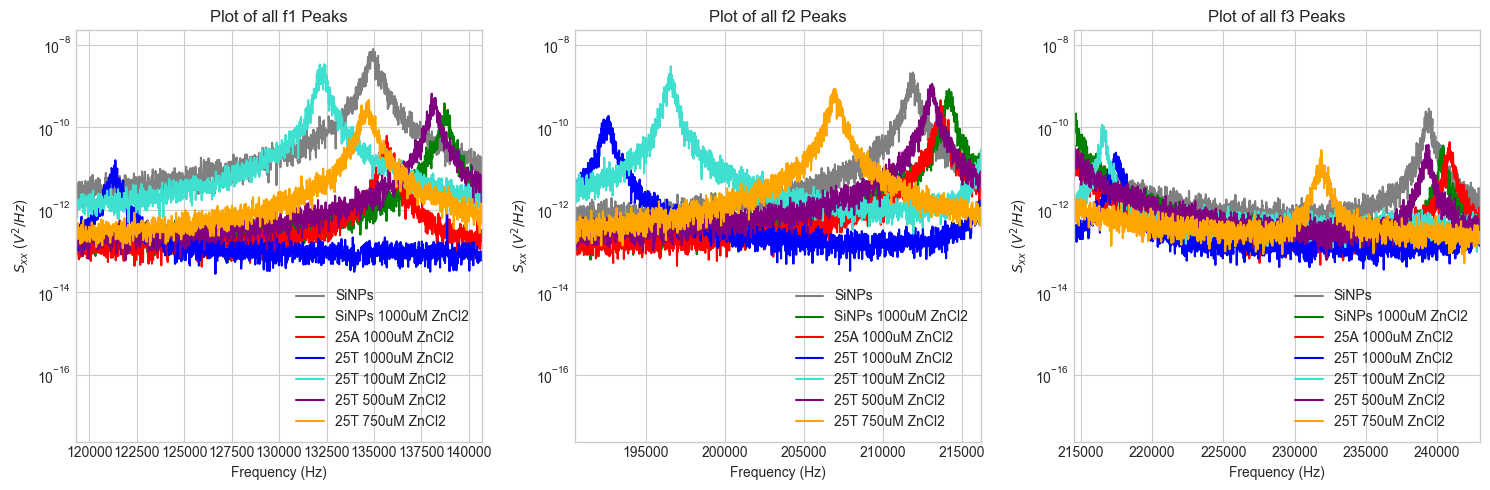

Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density


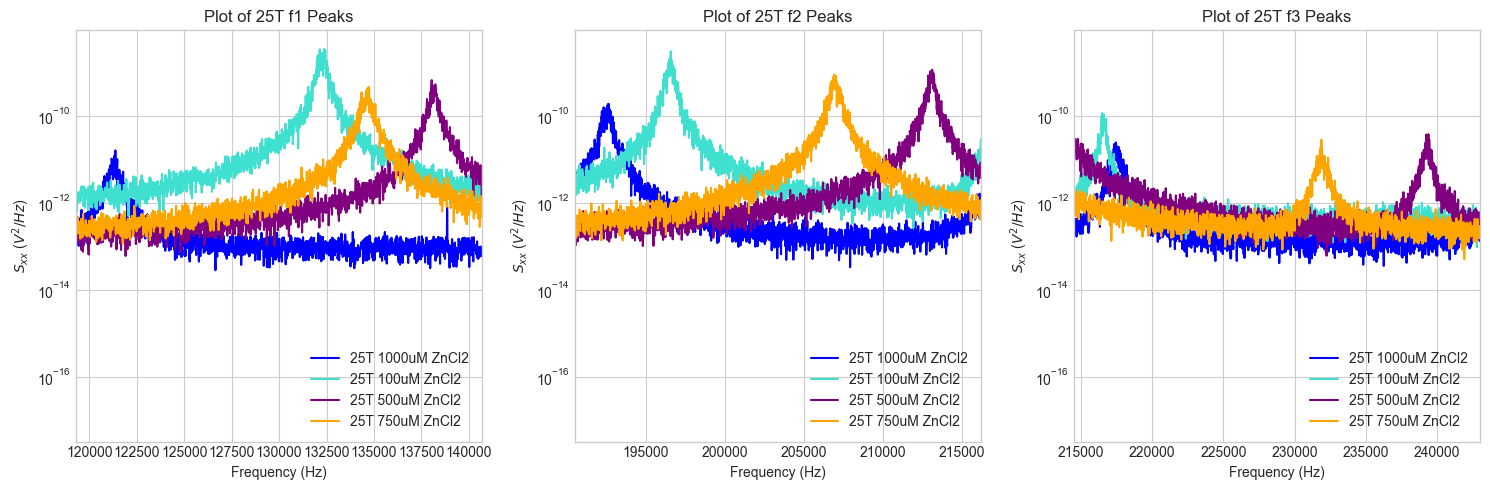

Calculating power spectral density
Calculating power spectral density
Calculating power spectral density


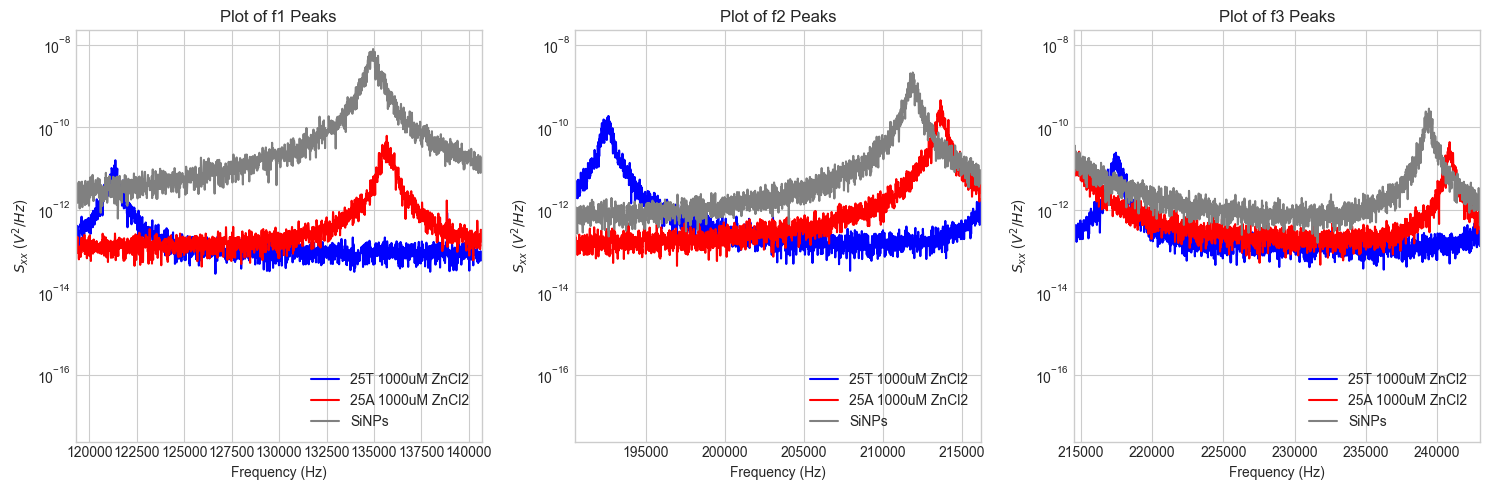

In [36]:
# Getting the plots for row 0
run_functions(0)

calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density


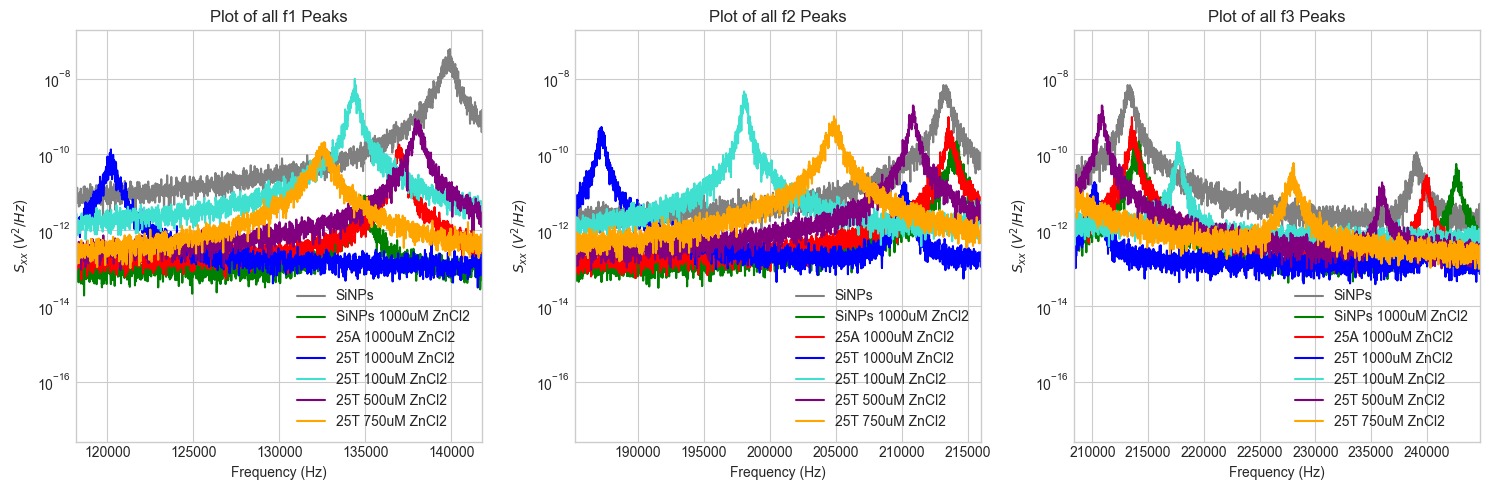

Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density


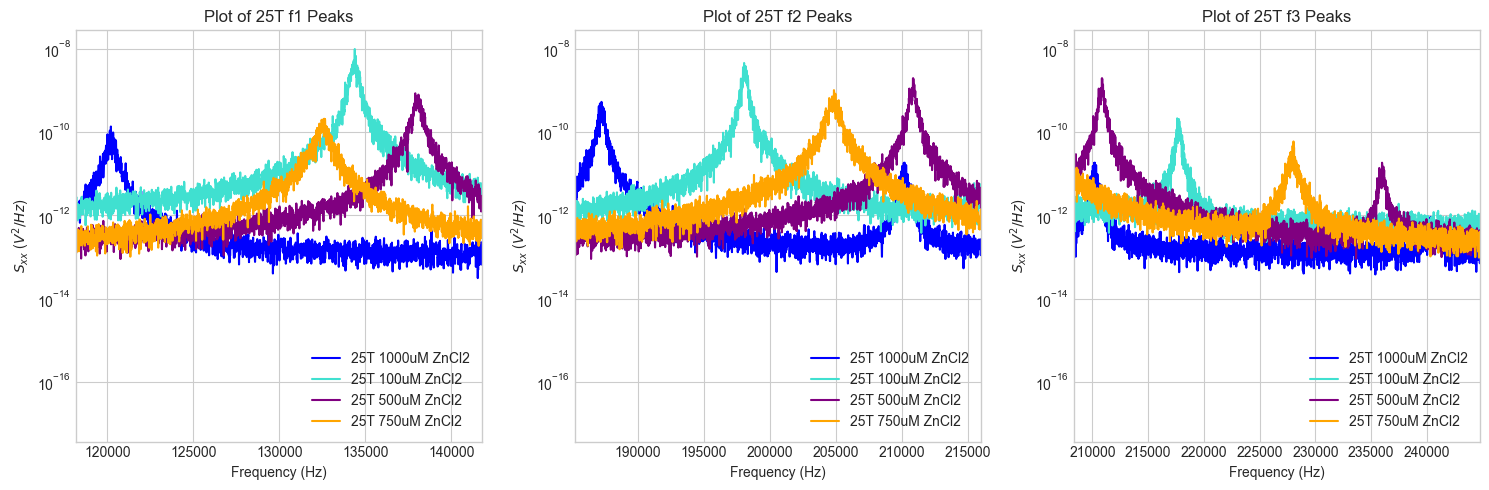

Calculating power spectral density
Calculating power spectral density
Calculating power spectral density


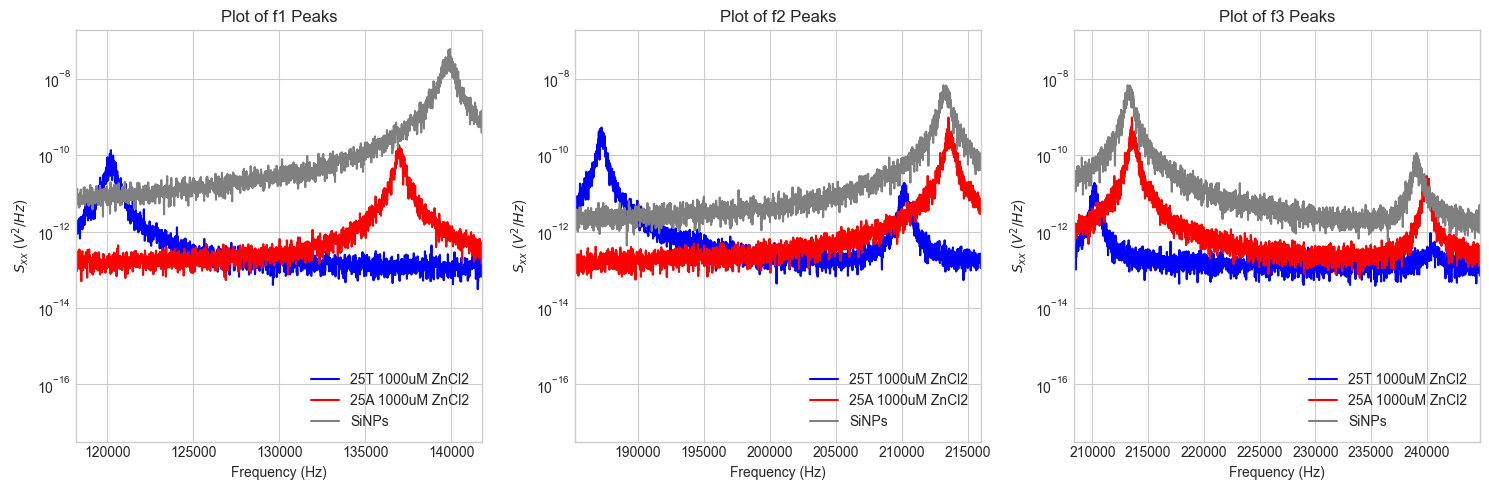

In [37]:
# Getting the plots for row 1
run_functions(1)

calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density


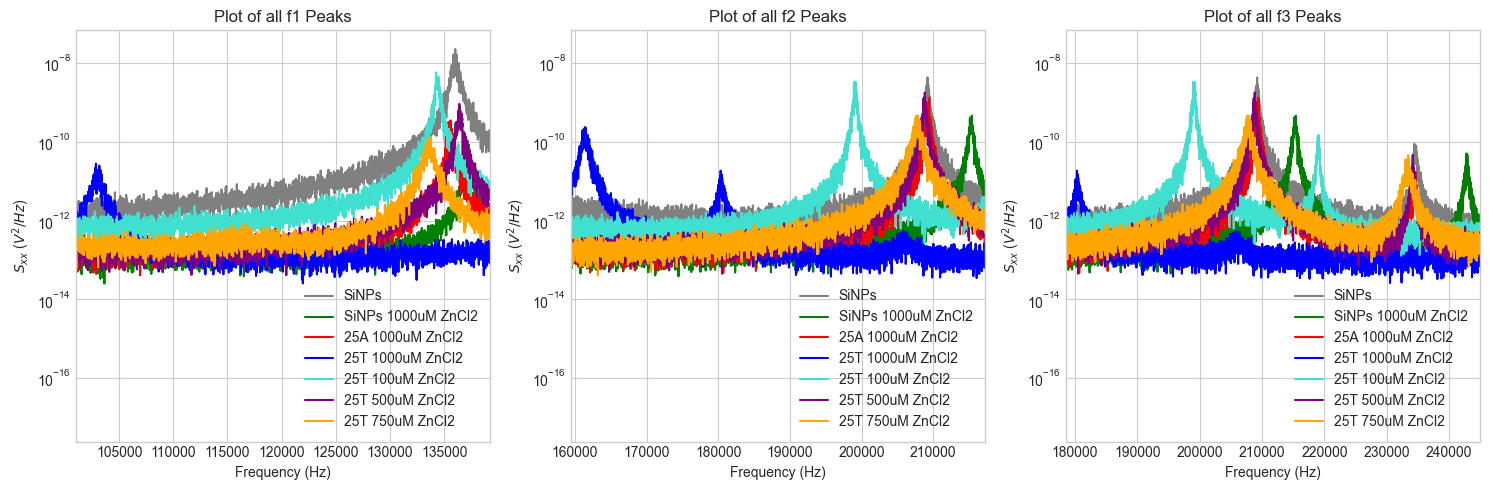

Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density


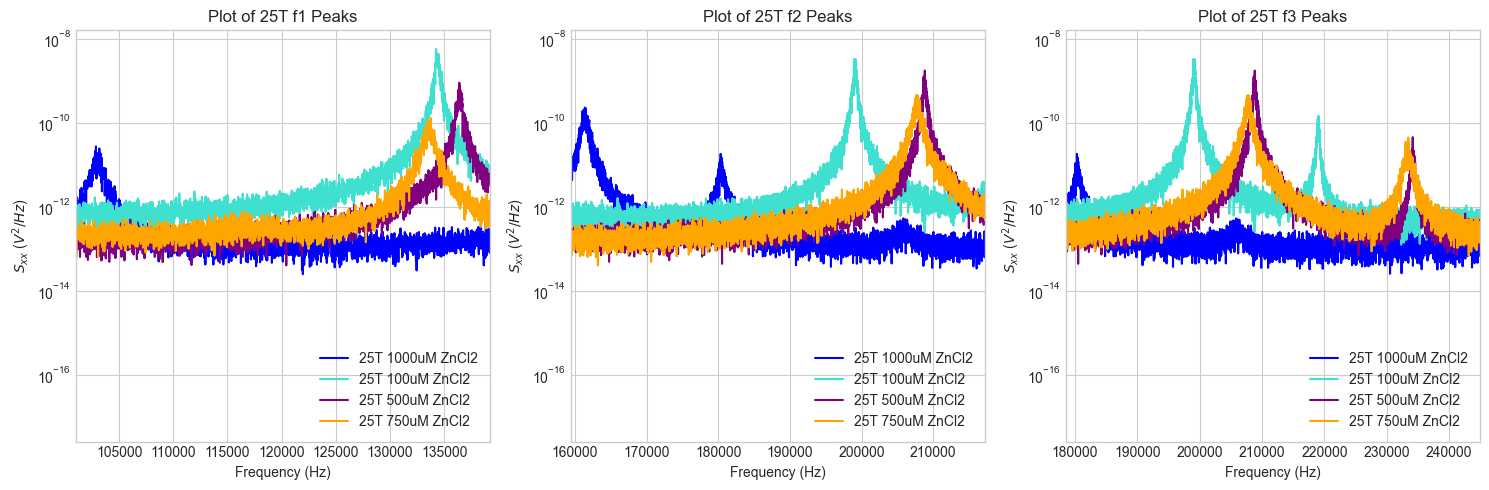

Calculating power spectral density
Calculating power spectral density
Calculating power spectral density


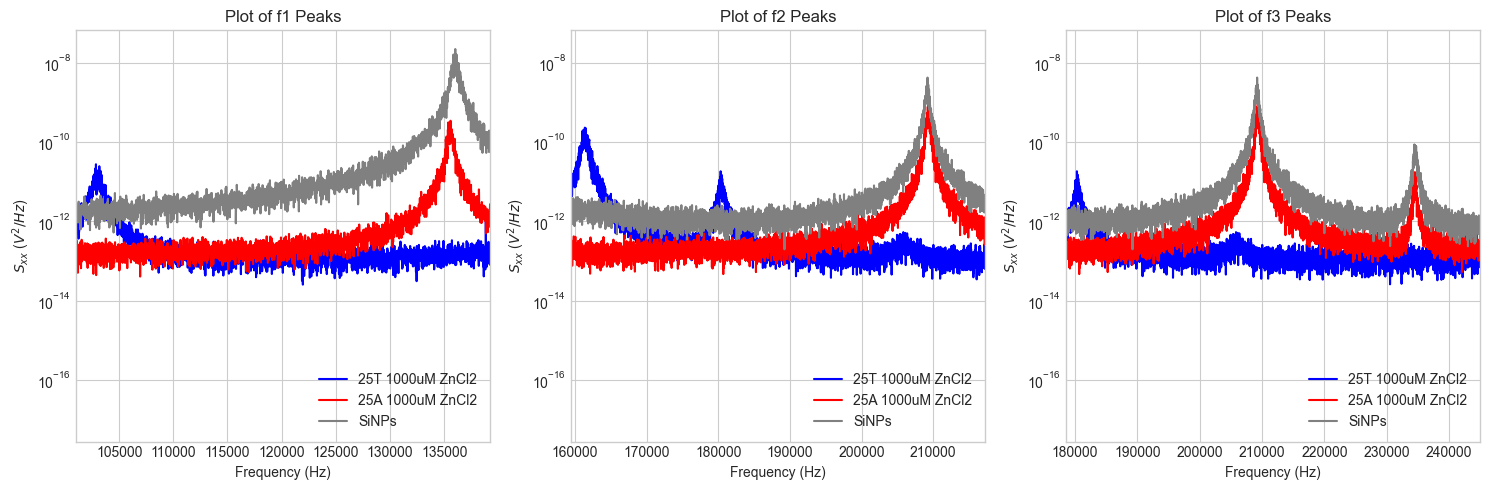

In [38]:
# Getting the plots for row 2
run_functions(2)

calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density


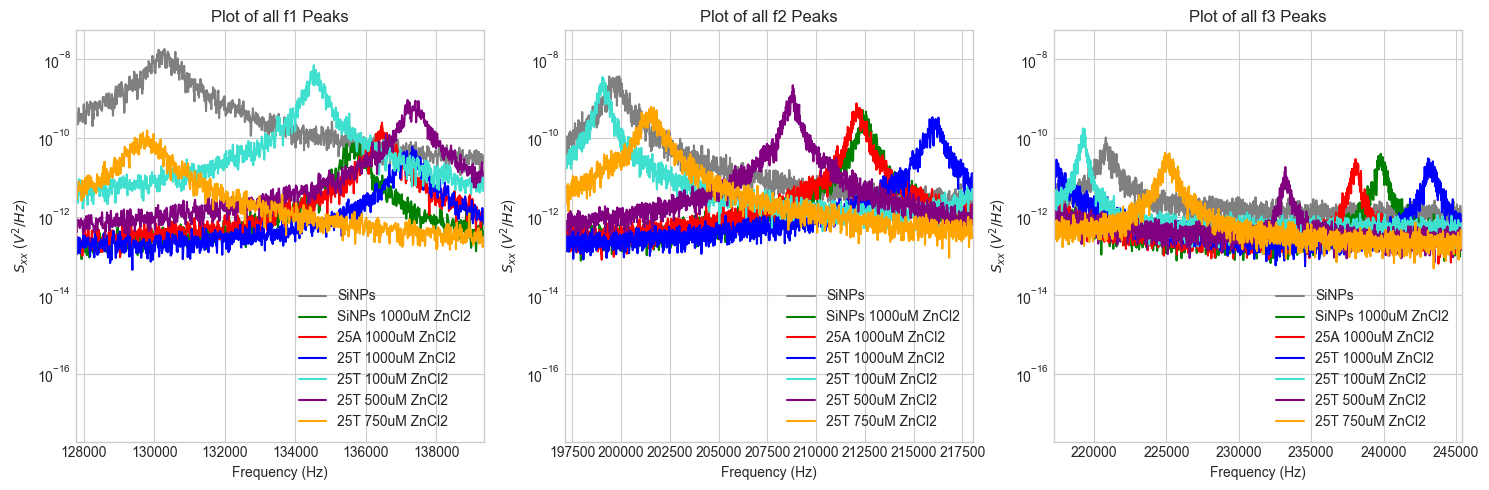

Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density


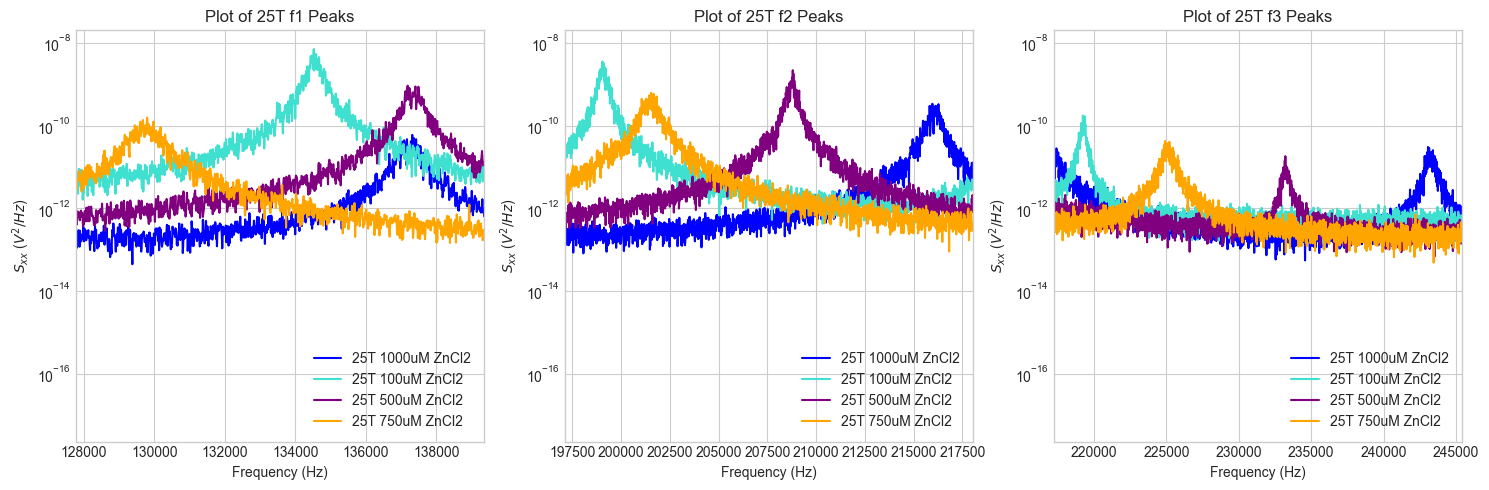

Calculating power spectral density
Calculating power spectral density
Calculating power spectral density


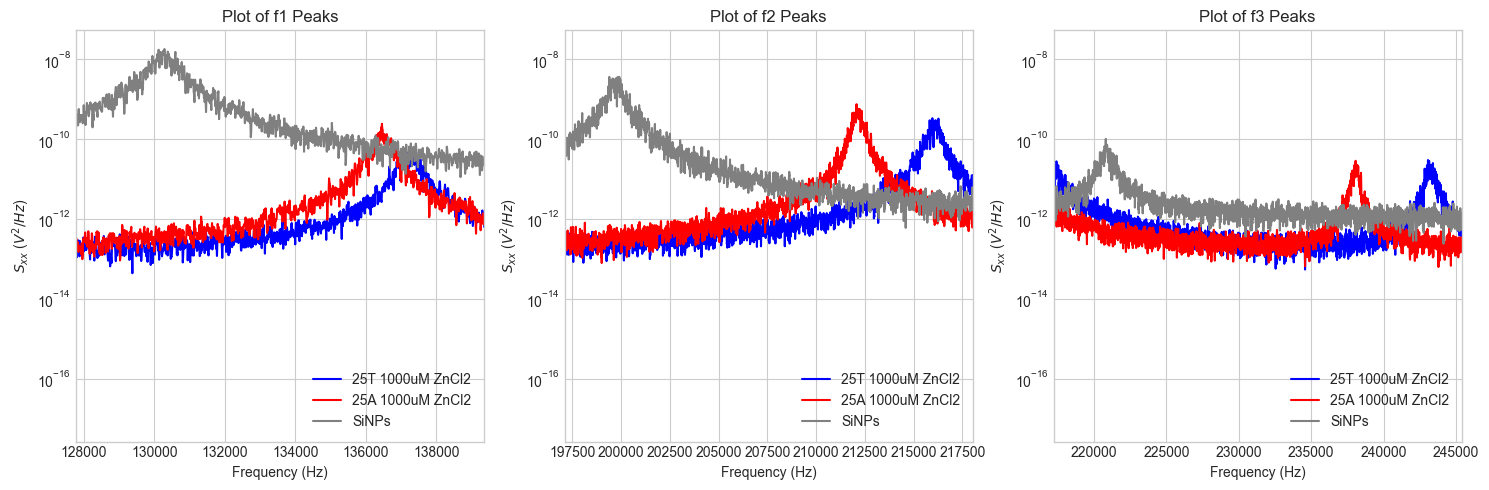

In [39]:
# Getting the plots for row 3
run_functions(3)

calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
calcPSD:  True
running self.get_PSD
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density


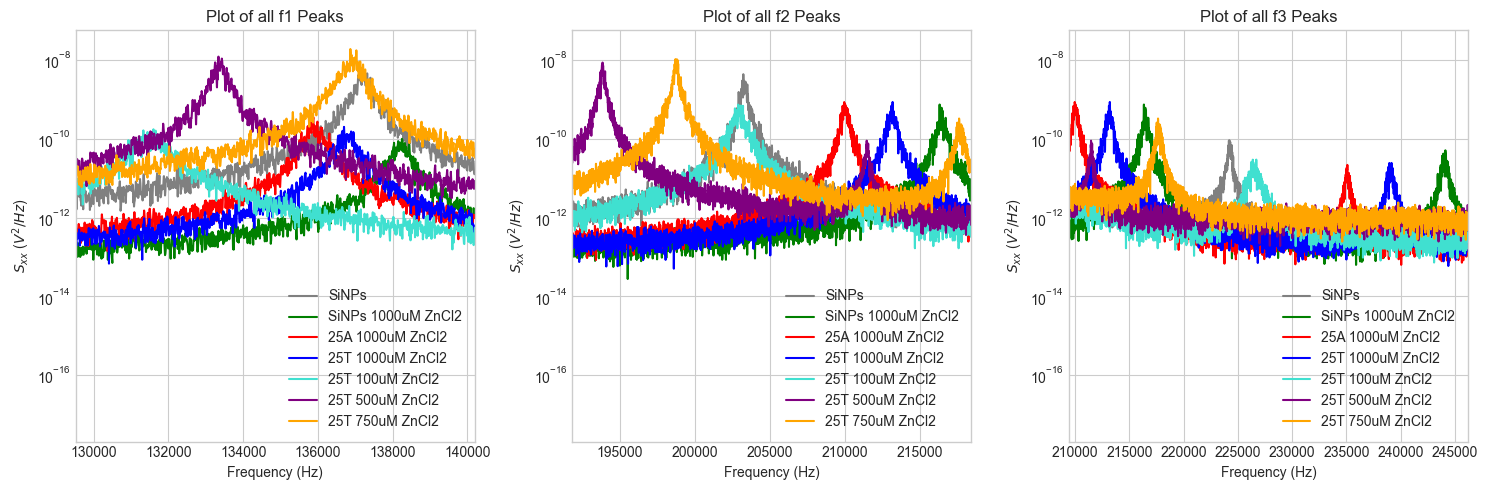

Calculating power spectral density
Calculating power spectral density
Calculating power spectral density
Calculating power spectral density


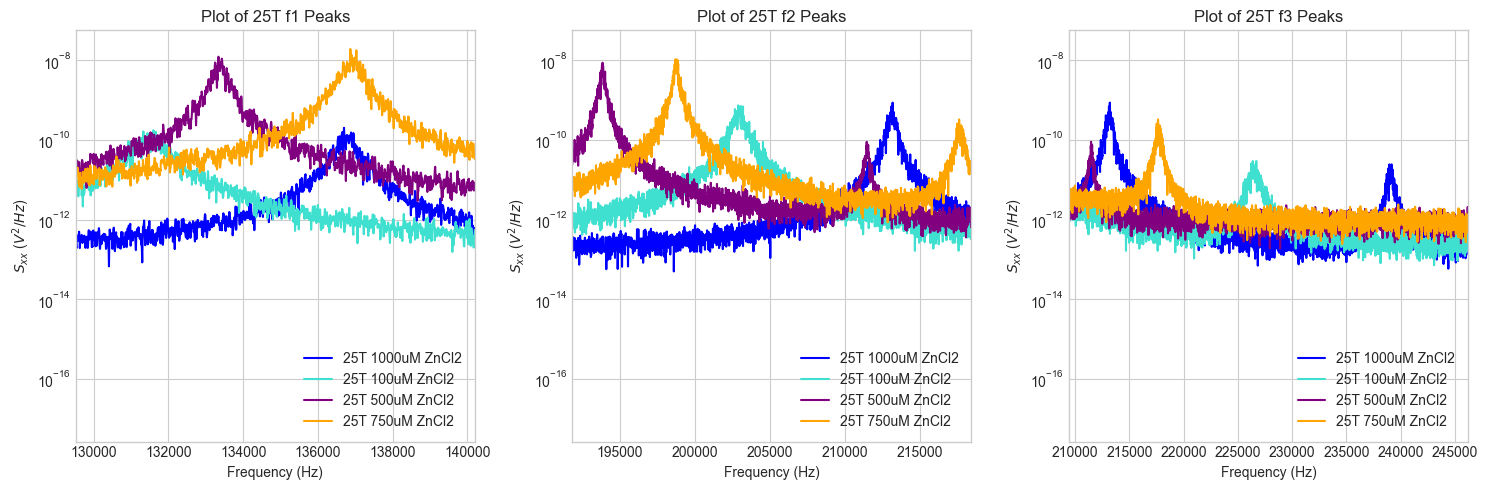

Calculating power spectral density
Calculating power spectral density
Calculating power spectral density


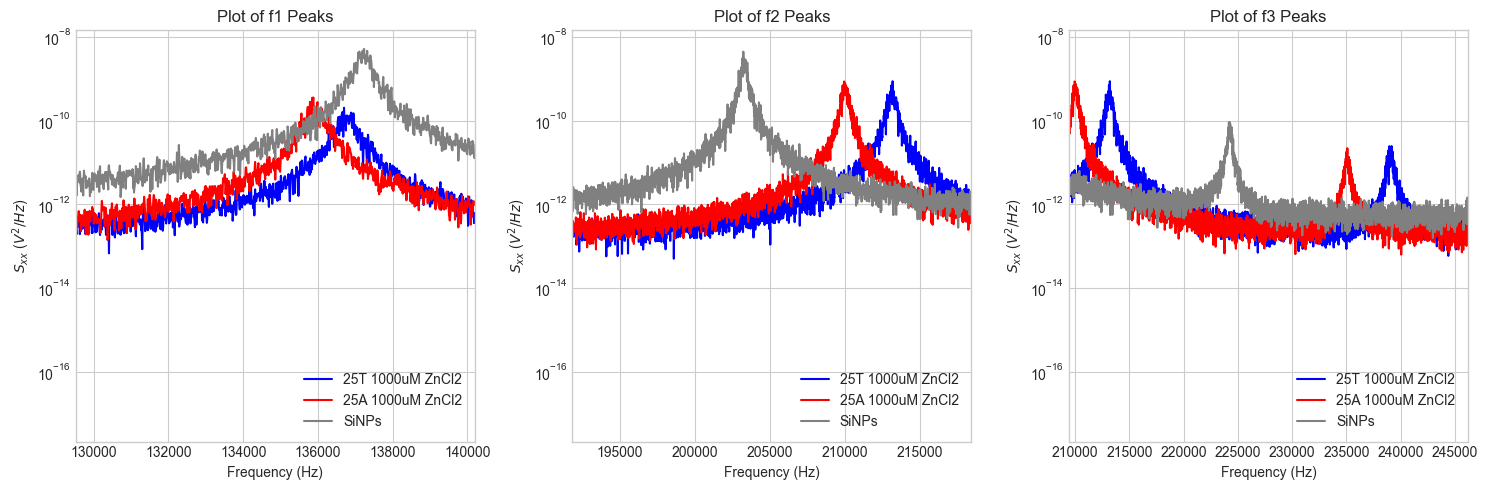

In [40]:
# Getting the plots for row 4
run_functions(4)

# END